In [1]:
import mcmc_utils

In [2]:
import surp
import vice
import numpy as np

import matplotlib.pyplot as plt

from surp.gce_math import Z_to_MH, MH_to_Z
from surp.yields import calc_y

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
from singlezone import run_singlezone

In [4]:
import arya

In [5]:
surp.set_yields()

In [6]:
from scipy.optimize import curve_fit

In [7]:
from surp.agb_interpolator import interpolator as agb_interpolator

## Single zone approximation

In [8]:
def agb_interpolator(ele, study, **kwargs):
    return surp.agb_interpolator.interpolator(ele, study=study, **kwargs)

In [9]:
import warnings

the final carbon abundance is
$$
Z_{\rm C}(t_{\rm end}) = \frac{y_{\rm C}}{1+\eta - r - \tau_{\star} / \tau_{\rm sfh}}
$$

In [10]:
def calc_y_sz(ele="c", ignore_warnings=True):
    if ignore_warnings:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sz, h = run_singlezone()
    
    Z_end = h[f"z({ele})"].iloc[-1]
    tau_star = 2.5
    η = 0.5
    r = 0.4
    tau_sfh = 14
    
    y0 = Z_end * (1 + η - r - tau_star / tau_sfh)
    
    return y0

In [11]:
vice.yields.ccsne.settings["fe"] + vice.yields.sneia.settings["fe"]

0.001243

In [12]:
calc_y_sz("fe")

np.float64(0.0012628892546872612)

In [13]:
vice.yields.ccsne.settings["c"] = 1e-4
vice.yields.agb.settings["c"] = agb_interpolator("c", study="cristallo11", prefactor=0)

calc_y_sz("c")

np.float64(0.00010060020617254566)

In [14]:
vice.yields.ccsne.settings["c"] = 0

for model in surp.AGB_MODELS:
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=model)
    y = calc_y_sz("c")

    print(model, "\t", f"{y:0.3e}")


cristallo11 	 5.636e-04
ventura13 	 6.149e-04
karakas16 	 6.984e-04
battino19 	 1.139e-03


In [15]:
vice.yields.ccsne.settings["c"] = 0

for model in surp.AGB_MODELS:
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=model)
    y = calc_y(ele="c")

    print(model, "\t", f"{y:0.3e}")


cristallo11 	 3.113e-04
ventura13 	 -8.581e-07
karakas16 	 2.956e-04
battino19 	 9.248e-04


In [16]:
?calc_y

Signature: calc_y(Z=0.0176, ele='c', kind='all', t_end=10)
Docstring: <no docstring>
File:      /arc7/home/dboyea/surp/surp/yields.py
Type:      function

In [17]:
for m_factor in [0.5, 0.7, 1, 1.5, 2]:
    vice.yields.agb.settings["c"] = agb_interpolator("c", study="cristallo11", mass_factor=m_factor)
    y = calc_y_sz("c")

    print(m_factor, "\t", f"{y:0.3e}")

0.5 	 5.619e-04
0.7 	 7.025e-04
1 	 5.636e-04
1.5 	 4.653e-04
2 	 4.139e-04


In [18]:
for m_factor in [0.5, 0.7, 1, 1.5, 2]:
    vice.yields.agb.settings["c"] = agb_interpolator("c", study="cristallo11", mass_factor=m_factor)
    y = calc_y(ele = "c")

    print(m_factor, "\t", f"{y:0.3e}")

0.5 	 2.832e-04
0.7 	 3.605e-04
1 	 3.113e-04
1.5 	 3.119e-04
2 	 3.002e-04


# MCMC Fits

# Prior models

In [16]:
lin_model = mcmc_utils.Linear(beta0=[3e-4, 3e-4], beta1=[0, 6e-4], log_sigma=[-20, 1])
exp_model = mcmc_utils.Exponential(beta0=[3e-4, 3e-3], beta1=[0,2e-2], log_sigma=[-20, 1])
quad_model = mcmc_utils.Quadratic(beta0=[3e-4, 3e-4], beta1=[0, 3e-4], beta2=[0, 3e-4], log_sigma=[-20, 1])

In [17]:
N = 3_000
discard = 300

100%|█████████████████████████████████████████████| 1000/1000 [00:12<00:00, 83.02it/s]


$\beta_0$ = 3.38e-04 + 3.12e-04 - 3.23e-04
$\beta_1$ = -9.33e-05 + 5.39e-04 - 6.28e-04
$\log(\sigma)$ = -2.00e+01 + 9.28e-01 - 8.69e-01


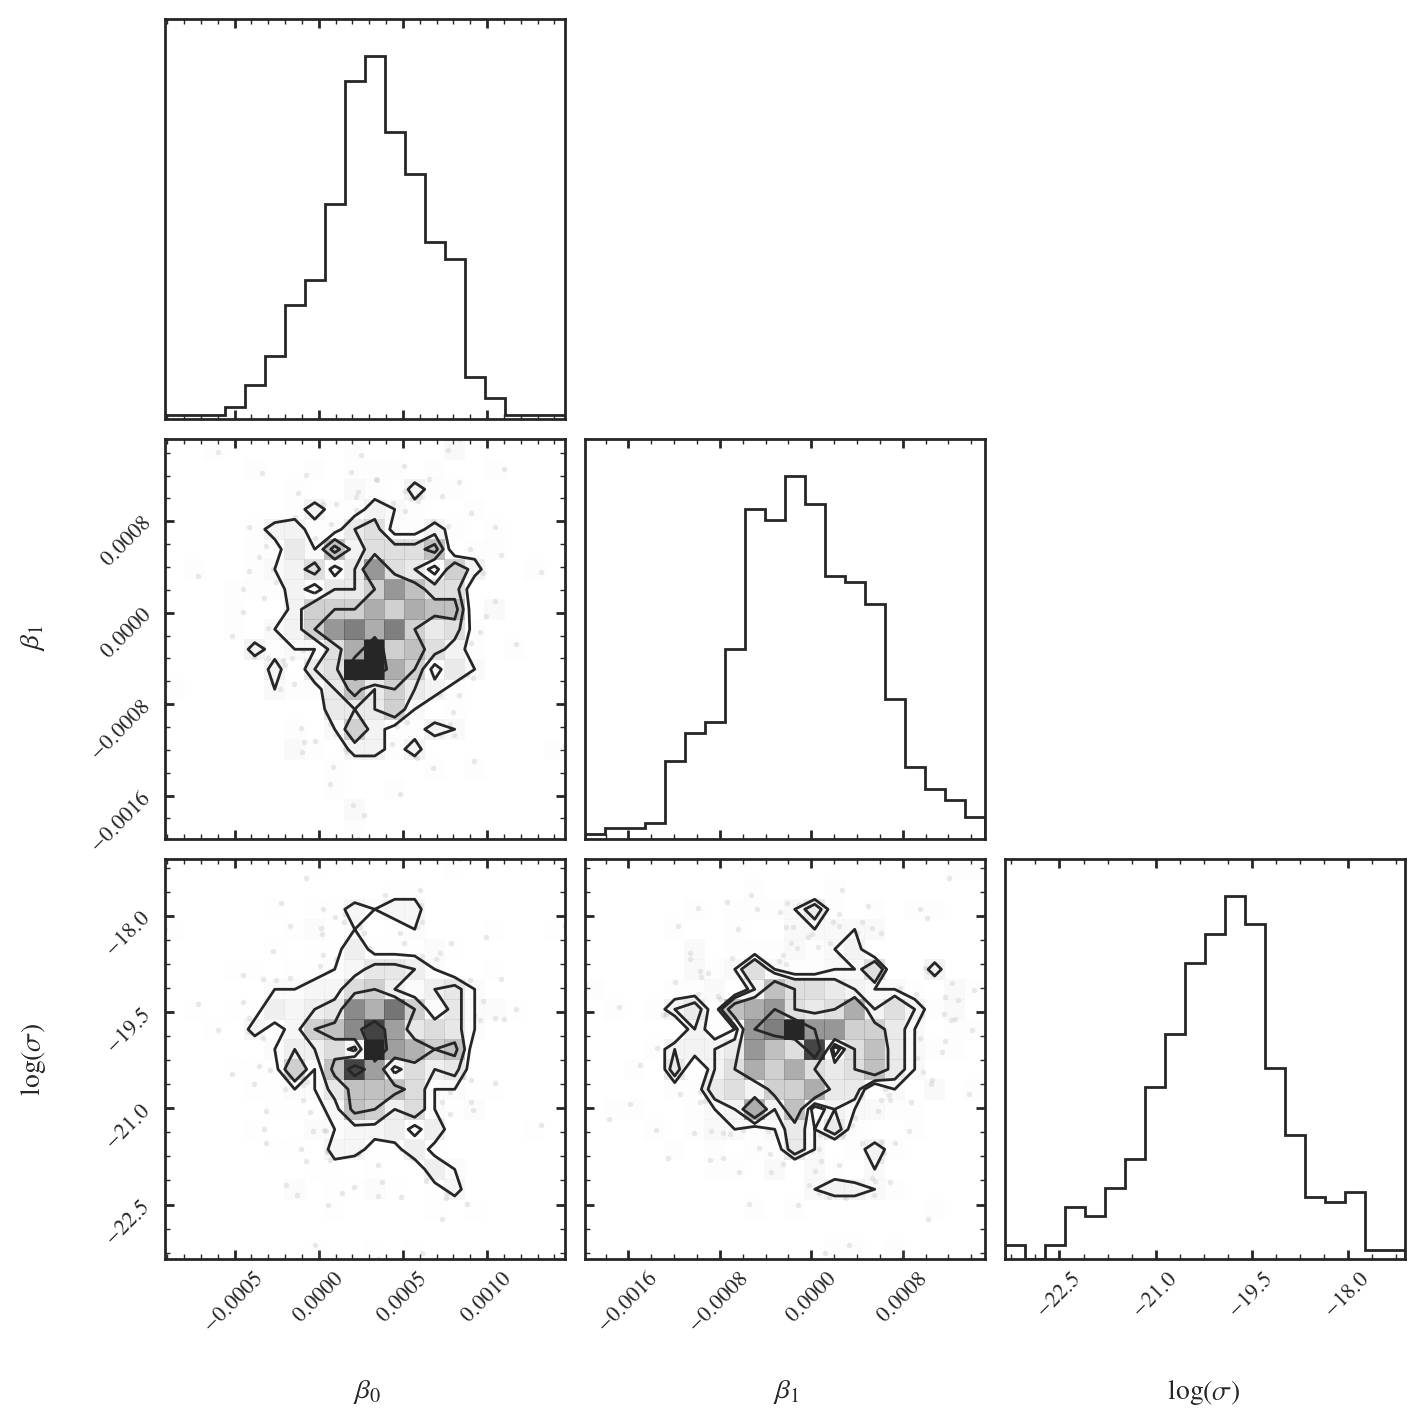

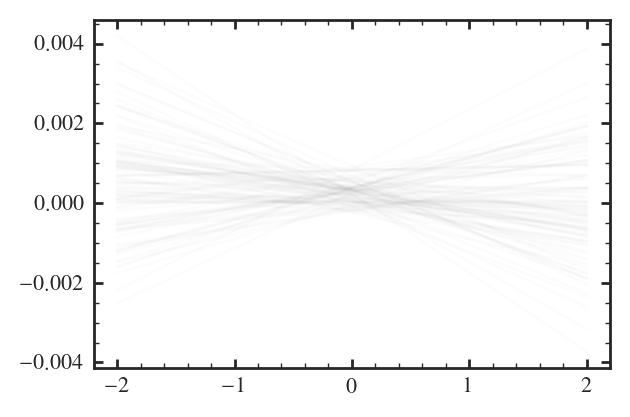

In [18]:
mcmc_utils.plot_prior(lin_model)

100%|█████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.05it/s]


$\beta_0$ = 2.20e-04 + 3.11e-03 - 3.30e-03
$\beta_1$ = 1.63e-03 + 2.07e-02 - 1.85e-02
$\log(\sigma)$ = 7.96e-01 + 4.06e+00 - 3.95e+00
$\alpha$ = -1.98e+01 + 1.10e+00 - 8.58e-01


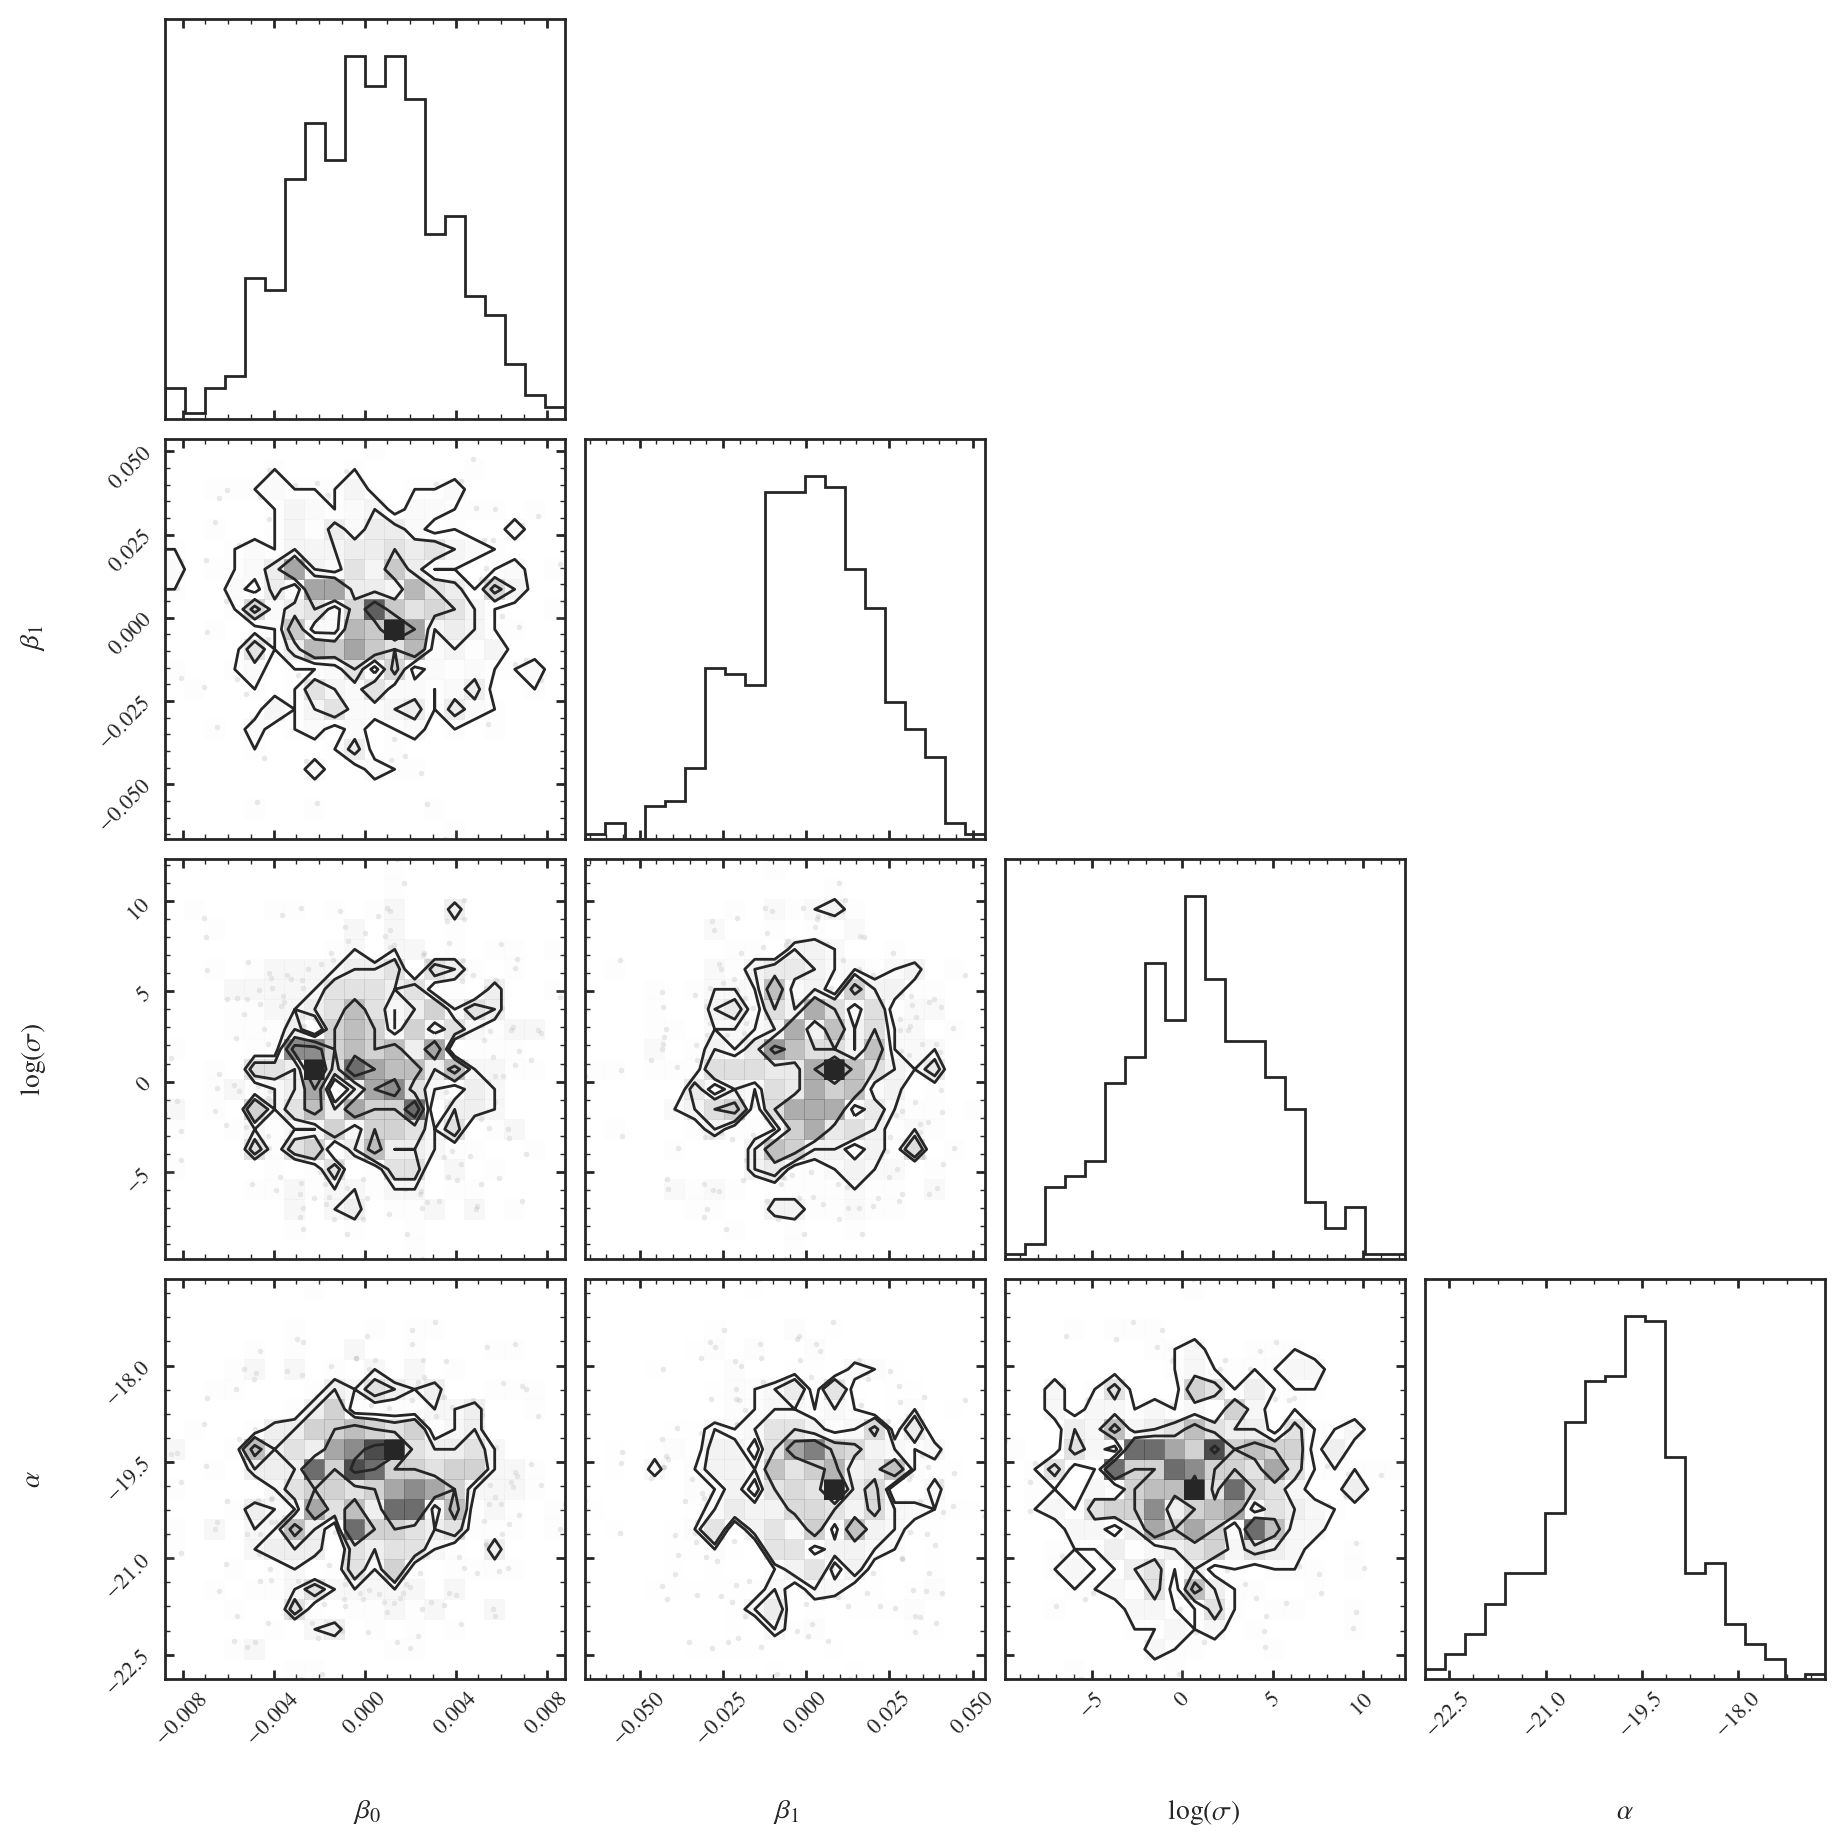

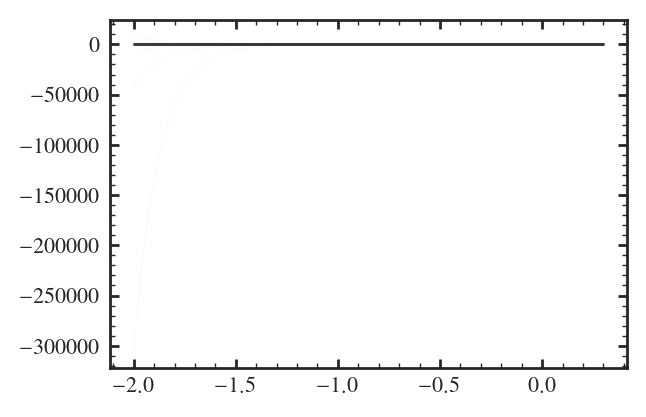

In [19]:
mcmc_utils.plot_prior(exp_model, xlims=(-2, 0.3))

100%|█████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.85it/s]


$\beta_0$ = 2.93e-04 + 3.31e-04 - 2.83e-04
$\beta_1$ = -1.58e-05 + 2.67e-04 - 2.83e-04
$\beta_2$ = 2.44e-06 + 3.35e-04 - 3.02e-04
$\log(\sigma)$ = -2.00e+01 + 1.10e+00 - 9.88e-01


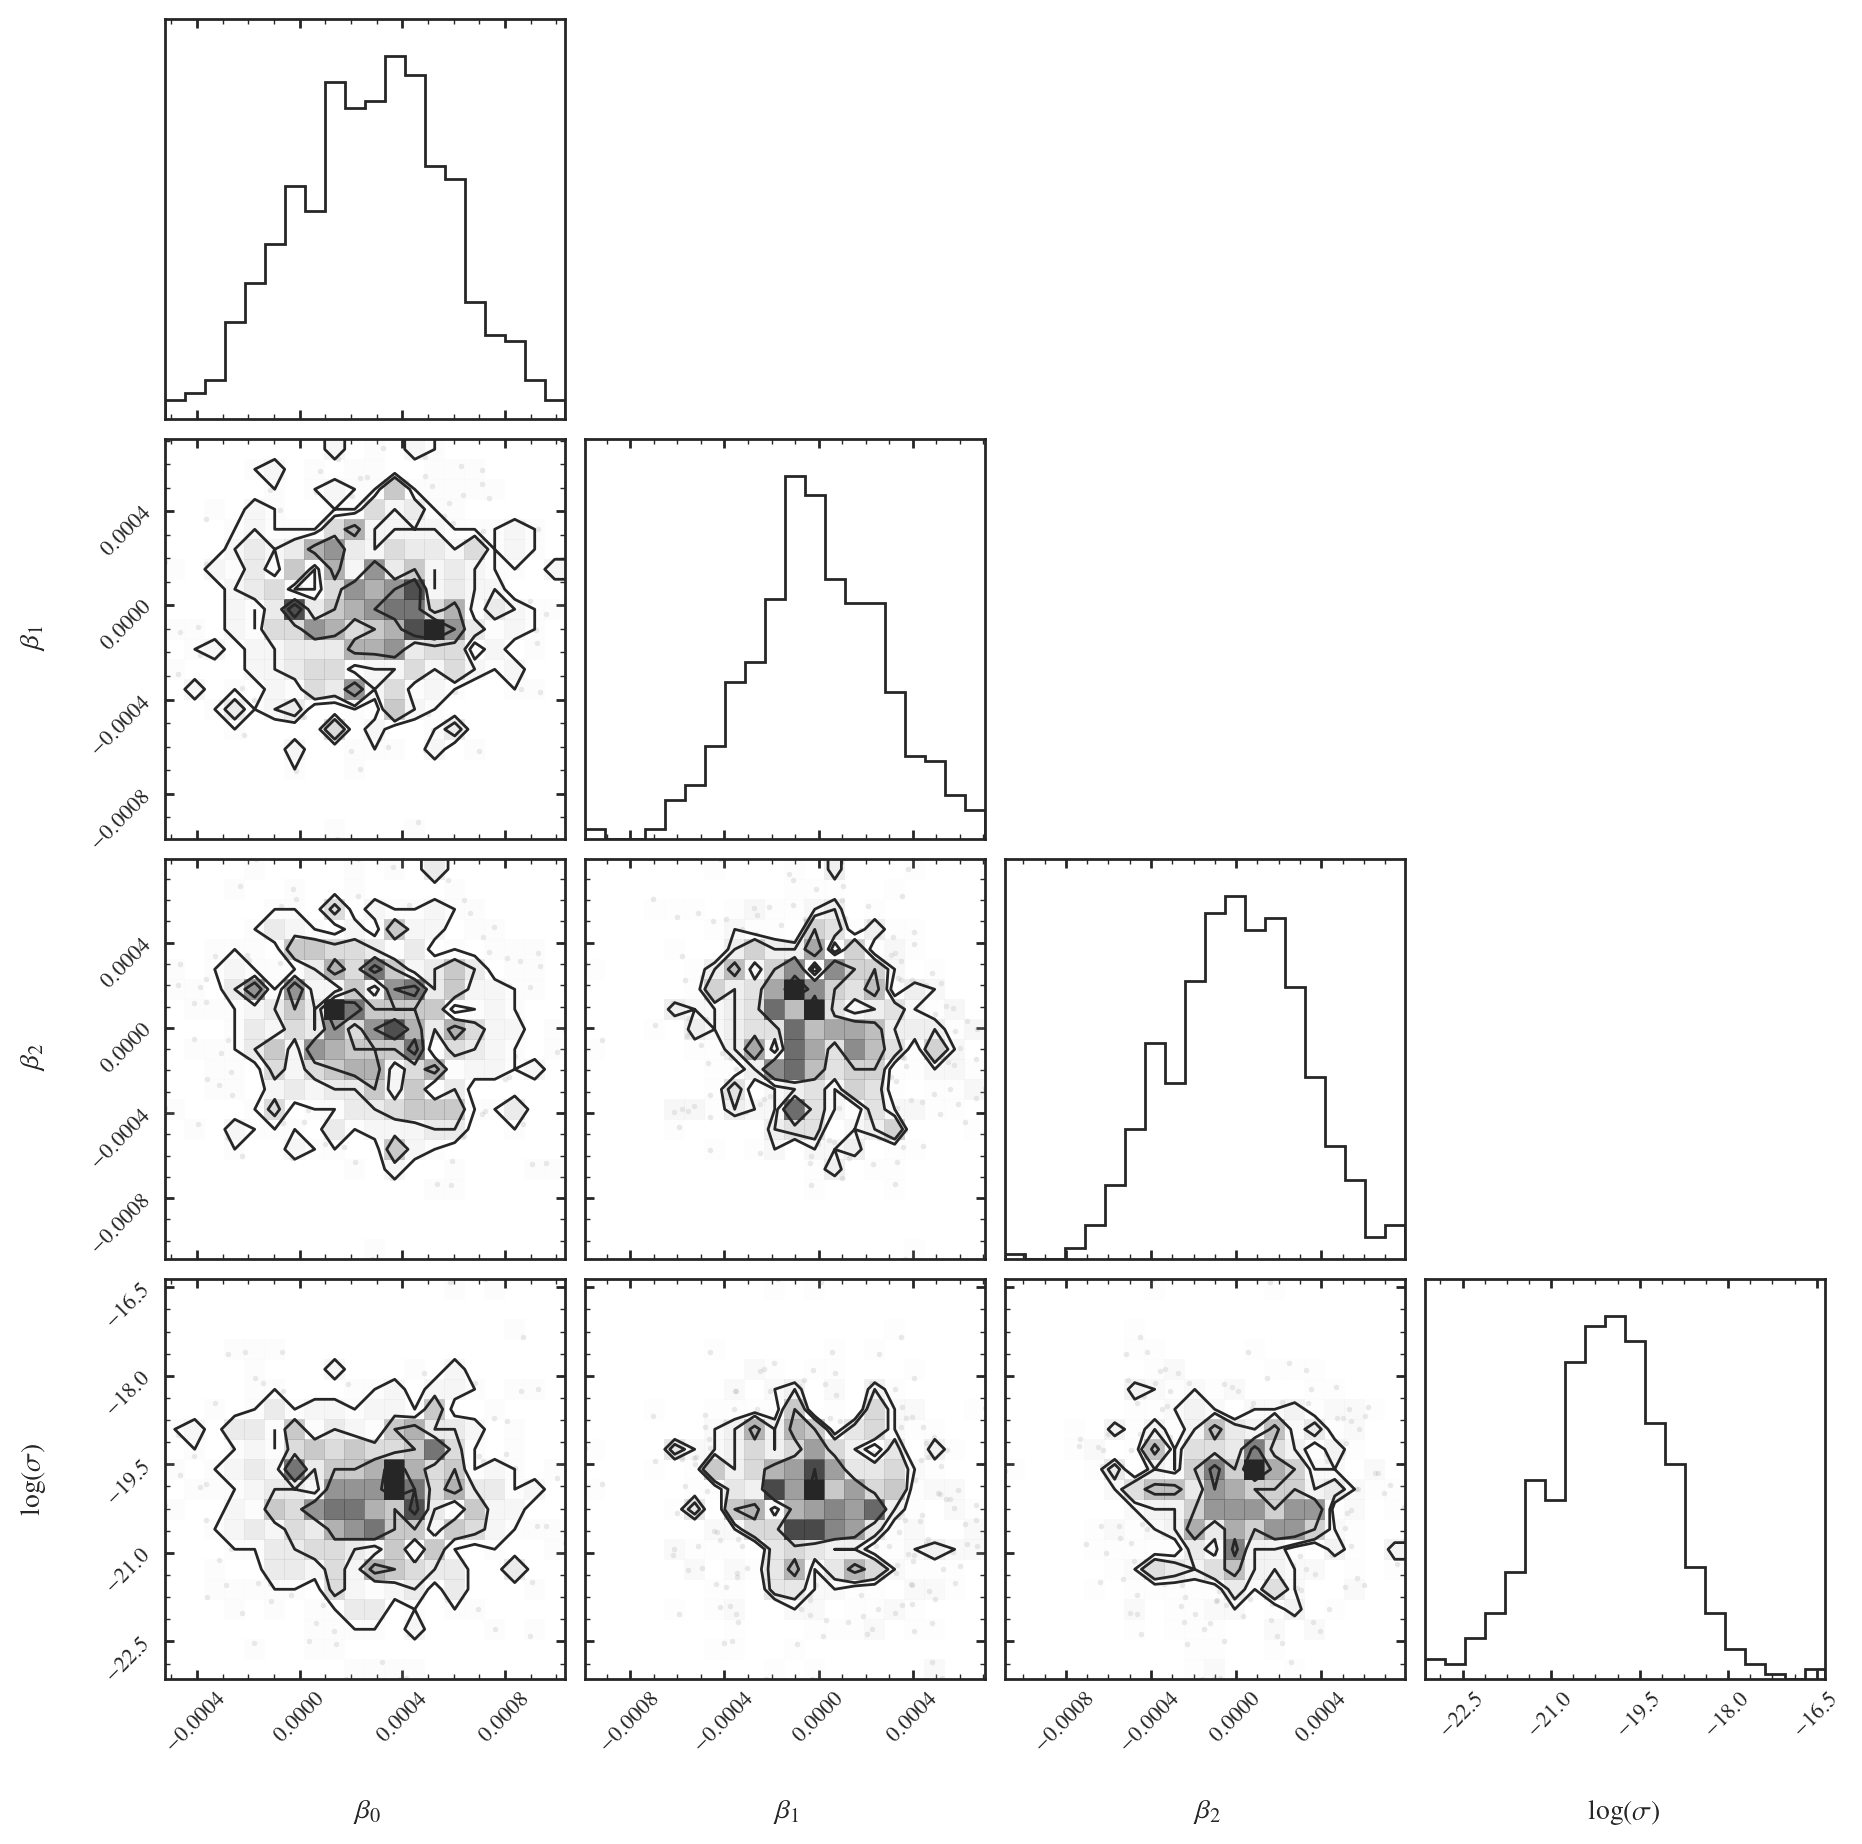

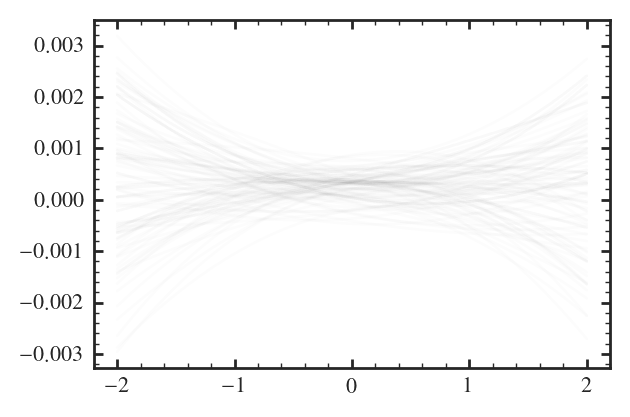

In [20]:
mcmc_utils.plot_prior(quad_model)

# Fit to the yield tables

In [19]:
def get_yield_table(study, **kwargs):
    y1, m1, z1 = vice.yields.agb.grid("c", study=study)
    mh1 = Z_to_MH(z1)
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=study, **kwargs)
    y_c_agb1 = np.array([calc_y(z, kind="agb") for z in z1])

    return mh1, y_c_agb1, None, None

In [20]:
obs = get_yield_table("cristallo11")

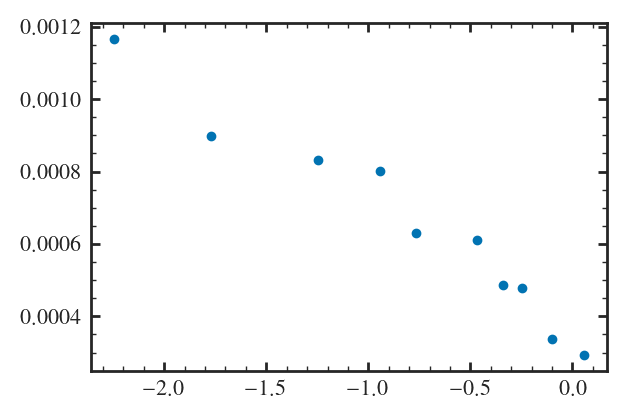

In [21]:
plt.scatter(obs[0], obs[1])

In [22]:
def lin_ls(x, a, b):
    return a + b*x

def quad_ls(x, a, b, c):
    return a + b*x + c*x**2

def exp_ls(x, a, b, c):
    return a + b*np.exp(c*x)


In [26]:
def fit_ls(obs, model, p0=None, color=arya.COLORS[1], **kwargs):
    popt, covt = curve_fit(model, obs[0], obs[1], p0=None)

    for i in range(len(popt)):
        print(["zeta0", "zeta1"][i], f":\t{popt[i]:8.3e}  ±  {np.sqrt(covt[i,i]):8.3e}")

    x = np.linspace(np.min(obs[0]), np.max(obs[0]), 1000)
    y = model(x, *popt)
    plt.plot(x, y, color=color, **kwargs)

    return popt

### Mass factor

In [39]:
alpha_0 = 2.40
a_0 = 0.37 # from linear fit to frutty

In [40]:
y_tot = (alpha_0 * a_0 + 1.90)

In [41]:
f_agb = alpha_0 * a_0 / y_tot

study cristallo11
y0 =  0.0003112949359076144
zeta0 :	3.691e-04  ±  3.075e-05
zeta1 :	-3.526e-04  ±  2.854e-05
alpha =  2.405665651164318

study ventura13
y0 =  -8.581162077687492e-07
zeta0 :	9.563e-05  ±  1.896e-04
zeta1 :	-1.030e-03  ±  2.632e-04
alpha =  9.285864719489116

study karakas16
y0 =  0.00029555471423535663
zeta0 :	2.338e-04  ±  4.869e-05
zeta1 :	-1.103e-03  ±  1.049e-04
alpha =  3.7979762483332866

study battino19
y0 =  0.0009248417861815101
zeta0 :	8.100e-04  ±  1.945e-04
zeta1 :	-4.649e-04  ±  1.659e-04
alpha =  1.0962460677841943



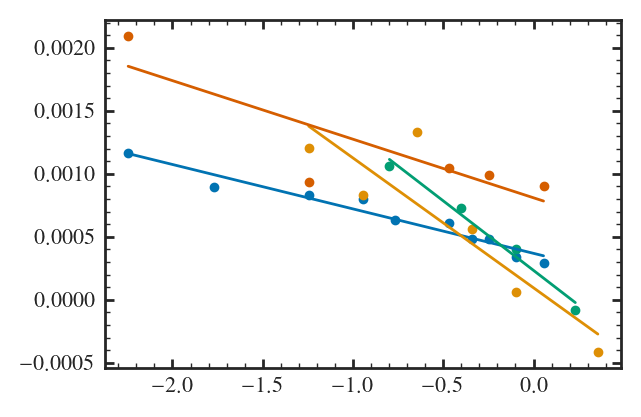

In [42]:
for study in surp.AGB_MODELS:
    print("study", study)
    obs = get_yield_table(study)
    if study == "ventura13":
        # remove lowest Z point
        obs = (obs[0][1:], obs[1][1:], None, None)
        
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=study)
    print("y0 = ", calc_y(ele="c"))
    a, b = fit_ls(obs, lin_ls, color=None)
    plt.scatter(obs[0], obs[1])

    alpha_exp = alpha_0 * a_0 /  (a) / 1e3
    print("alpha = ", alpha_exp)
    print()

mass factor =  0.5
y0 =  0.0002832489228255587
zeta0 :	3.287e-04  ±  2.396e-05
zeta1 :	-1.805e-04  ±  2.224e-05
alpha =  2.6942026131929686

mass factor =  0.7
y0 =  0.0003604729682654721
zeta0 :	4.194e-04  ±  3.055e-05
zeta1 :	-3.131e-04  ±  2.835e-05
alpha =  2.1117949591093366

mass factor =  1
y0 =  0.0003112949359076144
zeta0 :	3.691e-04  ±  3.075e-05
zeta1 :	-3.526e-04  ±  2.854e-05
alpha =  2.3991638521071166

mass factor =  1.5
y0 =  0.0003119140467531549
zeta0 :	3.405e-04  ±  2.464e-05
zeta1 :	-2.979e-04  ±  2.287e-05
alpha =  2.600610132829462

mass factor =  2
y0 =  0.00030021272144961295
zeta0 :	3.222e-04  ±  2.042e-05
zeta1 :	-2.268e-04  ±  1.895e-05
alpha =  2.748682574712448



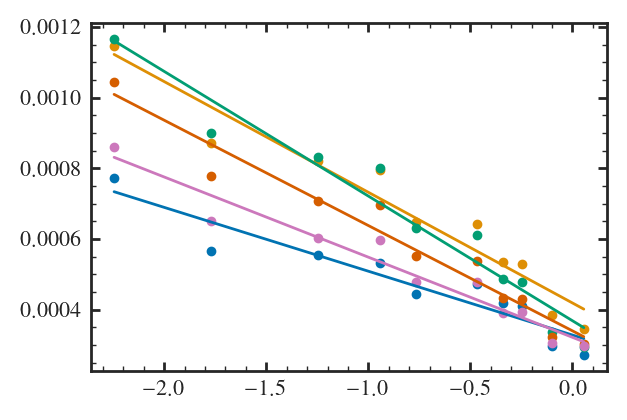

In [33]:
for mass_factor in [0.5, 0.7, 1,1.5, 2]:
    print("mass factor = ", mass_factor)
    obs = get_yield_table("cristallo11", mass_factor=mass_factor)
    vice.yields.agb.settings["c"] = agb_interpolator("c", study="cristallo11", mass_factor = mass_factor)
    print("y0 = ", calc_y(ele="c"))
    a, b = fit_ls(obs, lin_ls, color=None)
    plt.scatter(obs[0], obs[1])

    alpha_exp = alpha_0 * a_0 /  (a) / 1e3
    print("alpha = ", alpha_exp)
    print()

In [26]:
obs = get_yield_table("cristallo11")

### Normal investivation

100%|████████████████████████████████████████████| 3000/3000 [00:11<00:00, 254.56it/s]


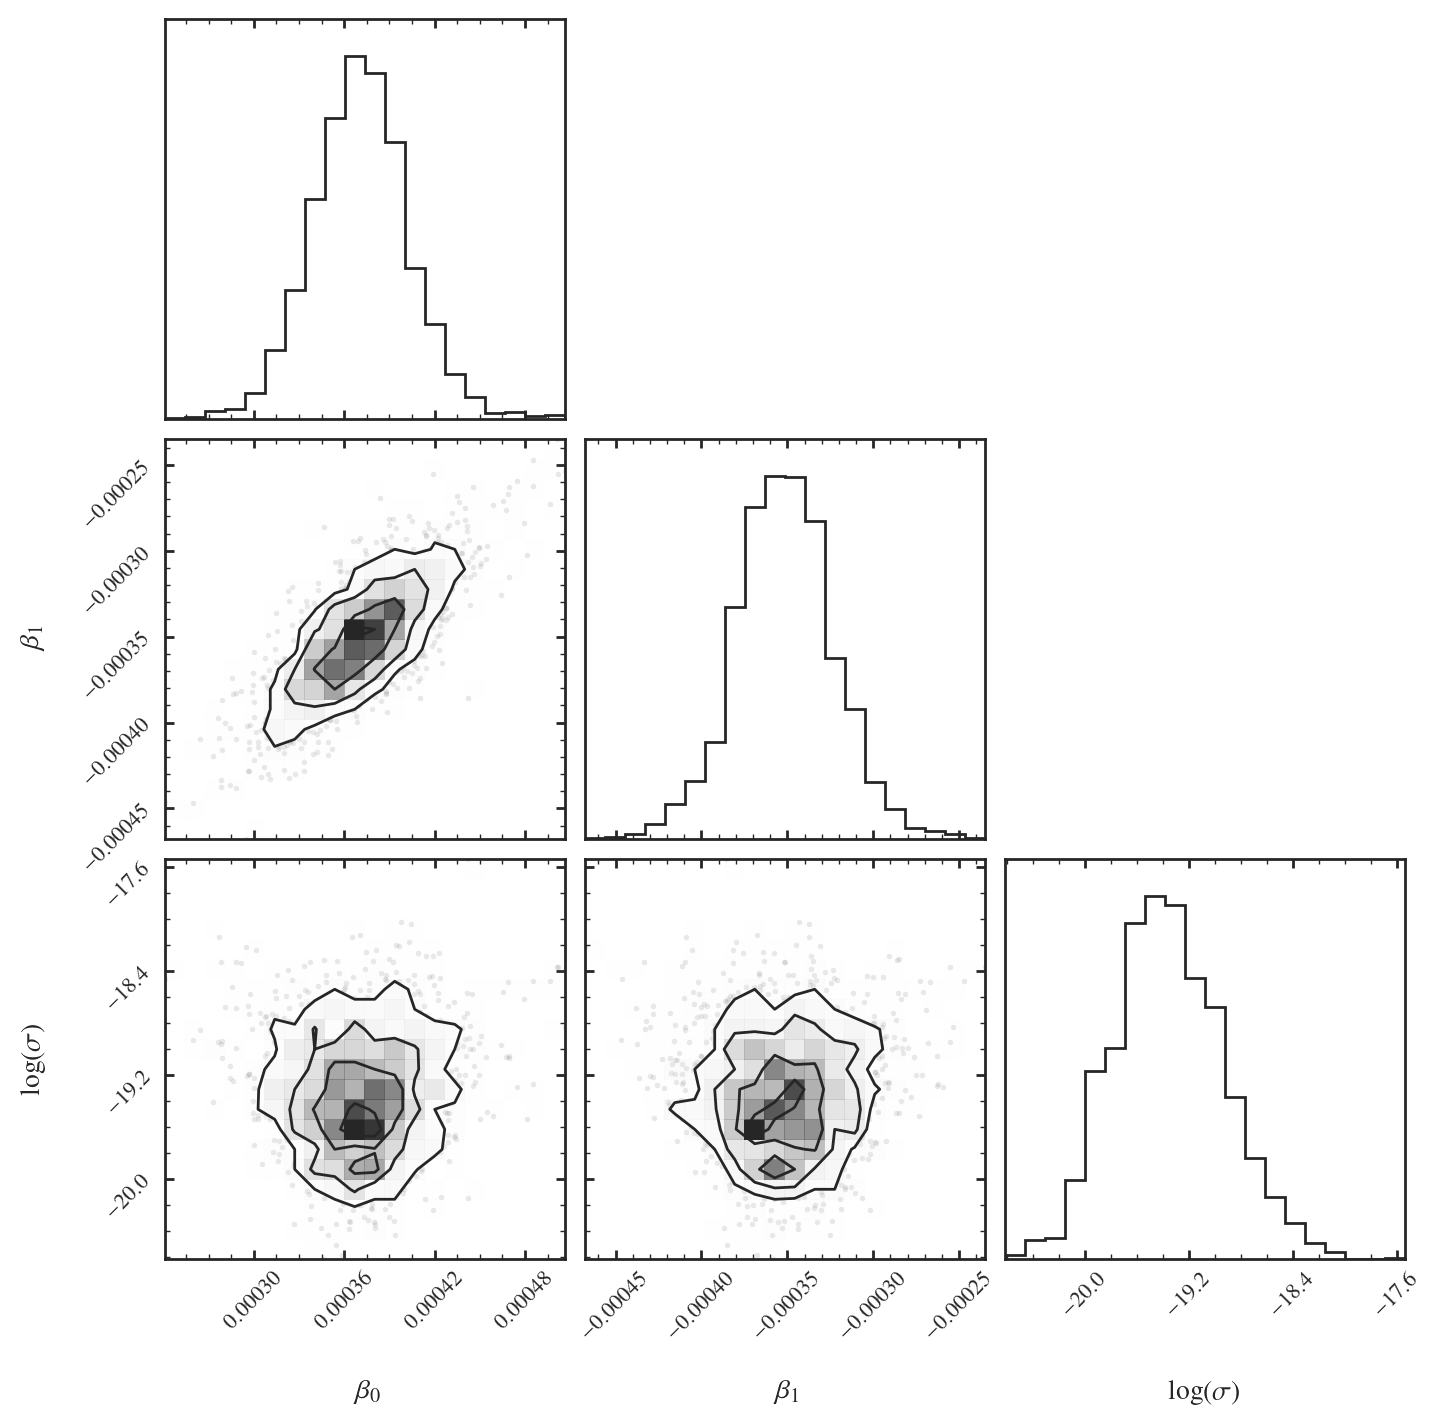

In [31]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 3.70e-04 + 3.02e-05 - 3.00e-05
$\beta_1$ = -3.52e-04 + 2.70e-05 - 2.79e-05
$\log(\sigma)$ = -1.94e+01 + 4.04e-01 - 4.38e-01
3.691e-04  ±  3.075e-05
-3.526e-04  ±  2.854e-05


array([ 0.00036913, -0.00035263])

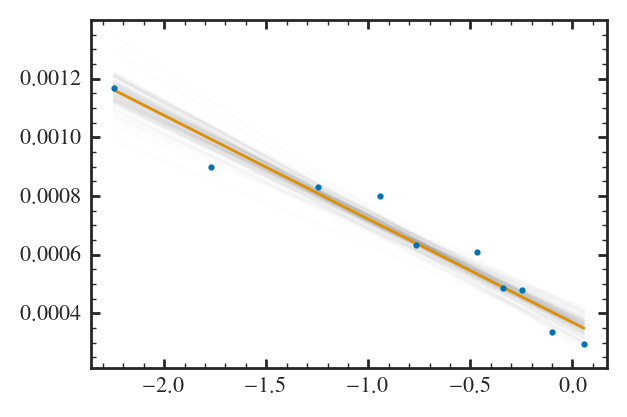

In [32]:
mcmc_utils.plot_posterior(lin_model, obs, samples)
fit_ls(obs, lin_ls)

100%|████████████████████████████████████████████| 3000/3000 [00:14<00:00, 205.82it/s]


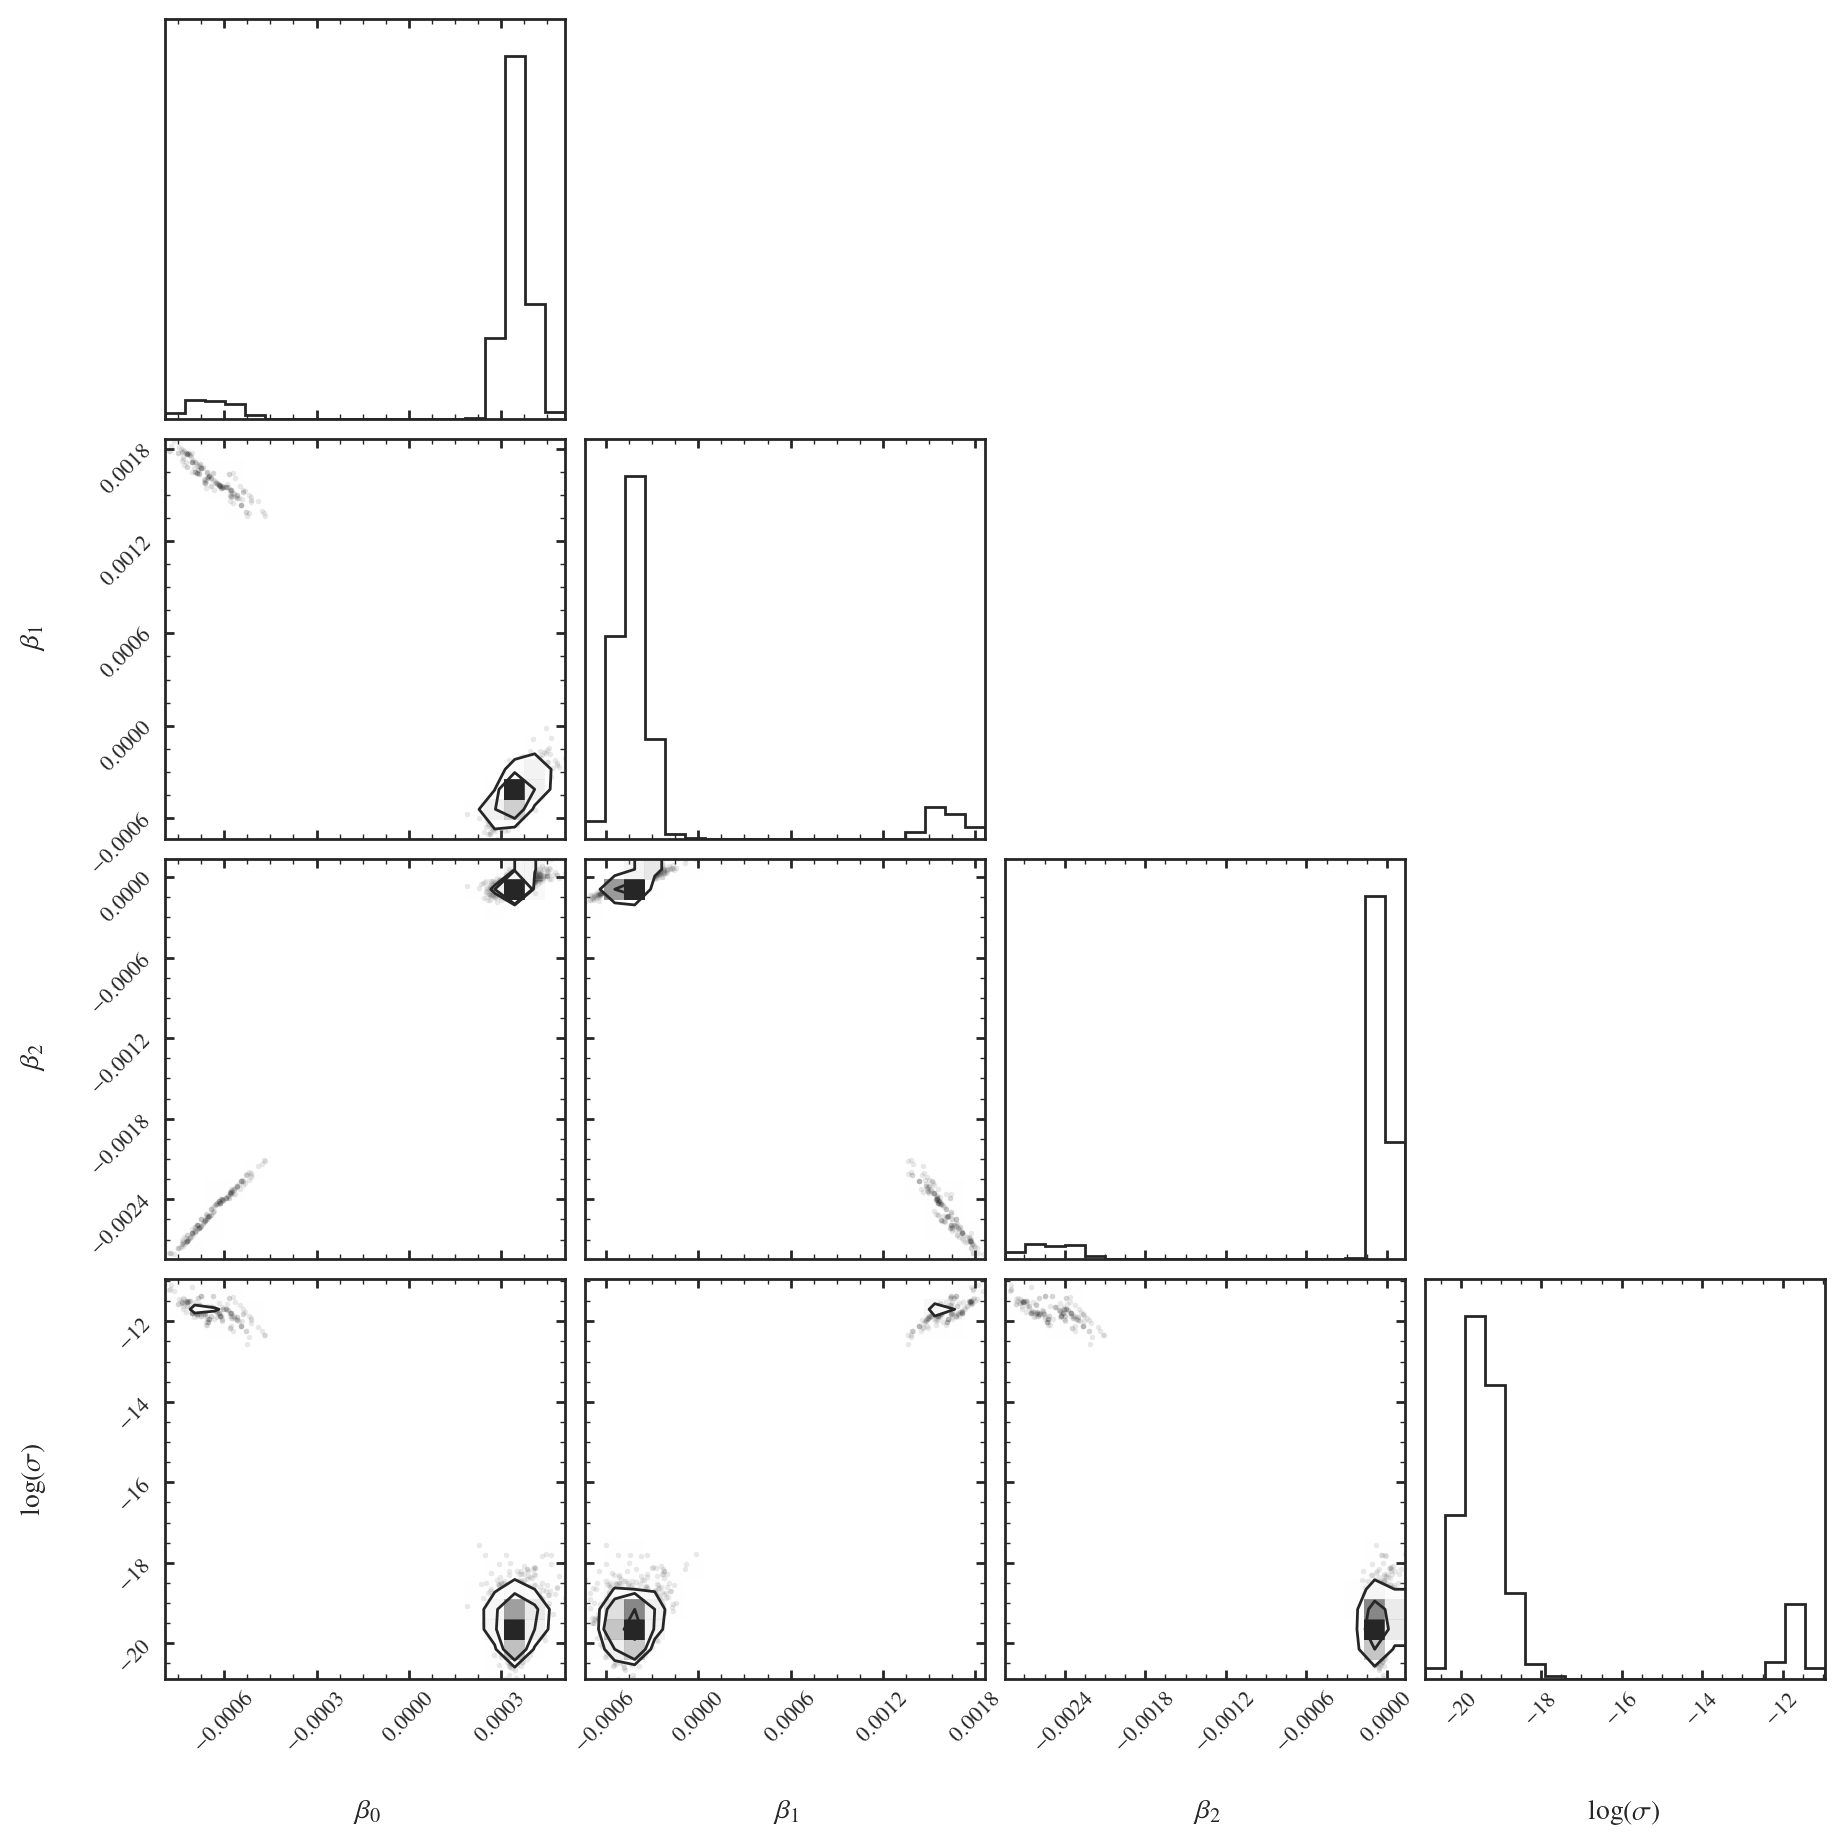

In [33]:
samples = mcmc_utils.run_mcmc(quad_model, obs, N=N, discard=discard)

$\beta_0$ = 3.43e-04 + 4.86e-05 - 4.00e-05
$\beta_1$ = -4.30e-04 + 8.74e-05 - 1.28e-04
$\beta_2$ = -4.73e-05 + 5.38e-05 - 3.88e-05
$\log(\sigma)$ = -1.94e+01 + 4.90e-01 - 6.58e-01
3.362e-04  ±  3.695e-05
-4.780e-04  ±  9.166e-05
-5.880e-05  ±  4.111e-05


array([ 3.36237173e-04, -4.77969123e-04, -5.87993771e-05])

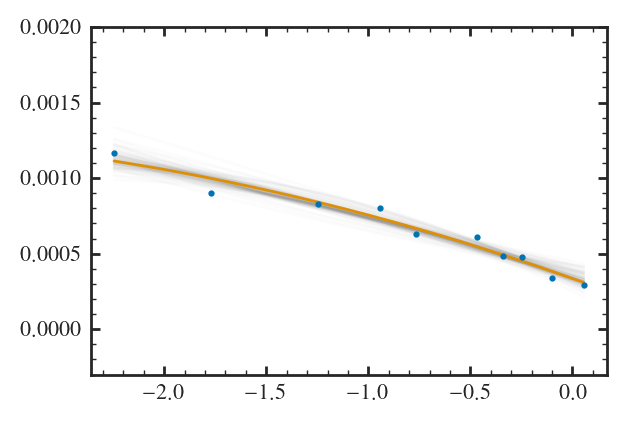

In [34]:
mcmc_utils.plot_posterior(quad_model, obs, samples)
plt.ylim(-0.3e-3, 2e-3)
fit_ls(obs, quad_ls)

100%|████████████████████████████████████████████| 3000/3000 [00:15<00:00, 198.70it/s]


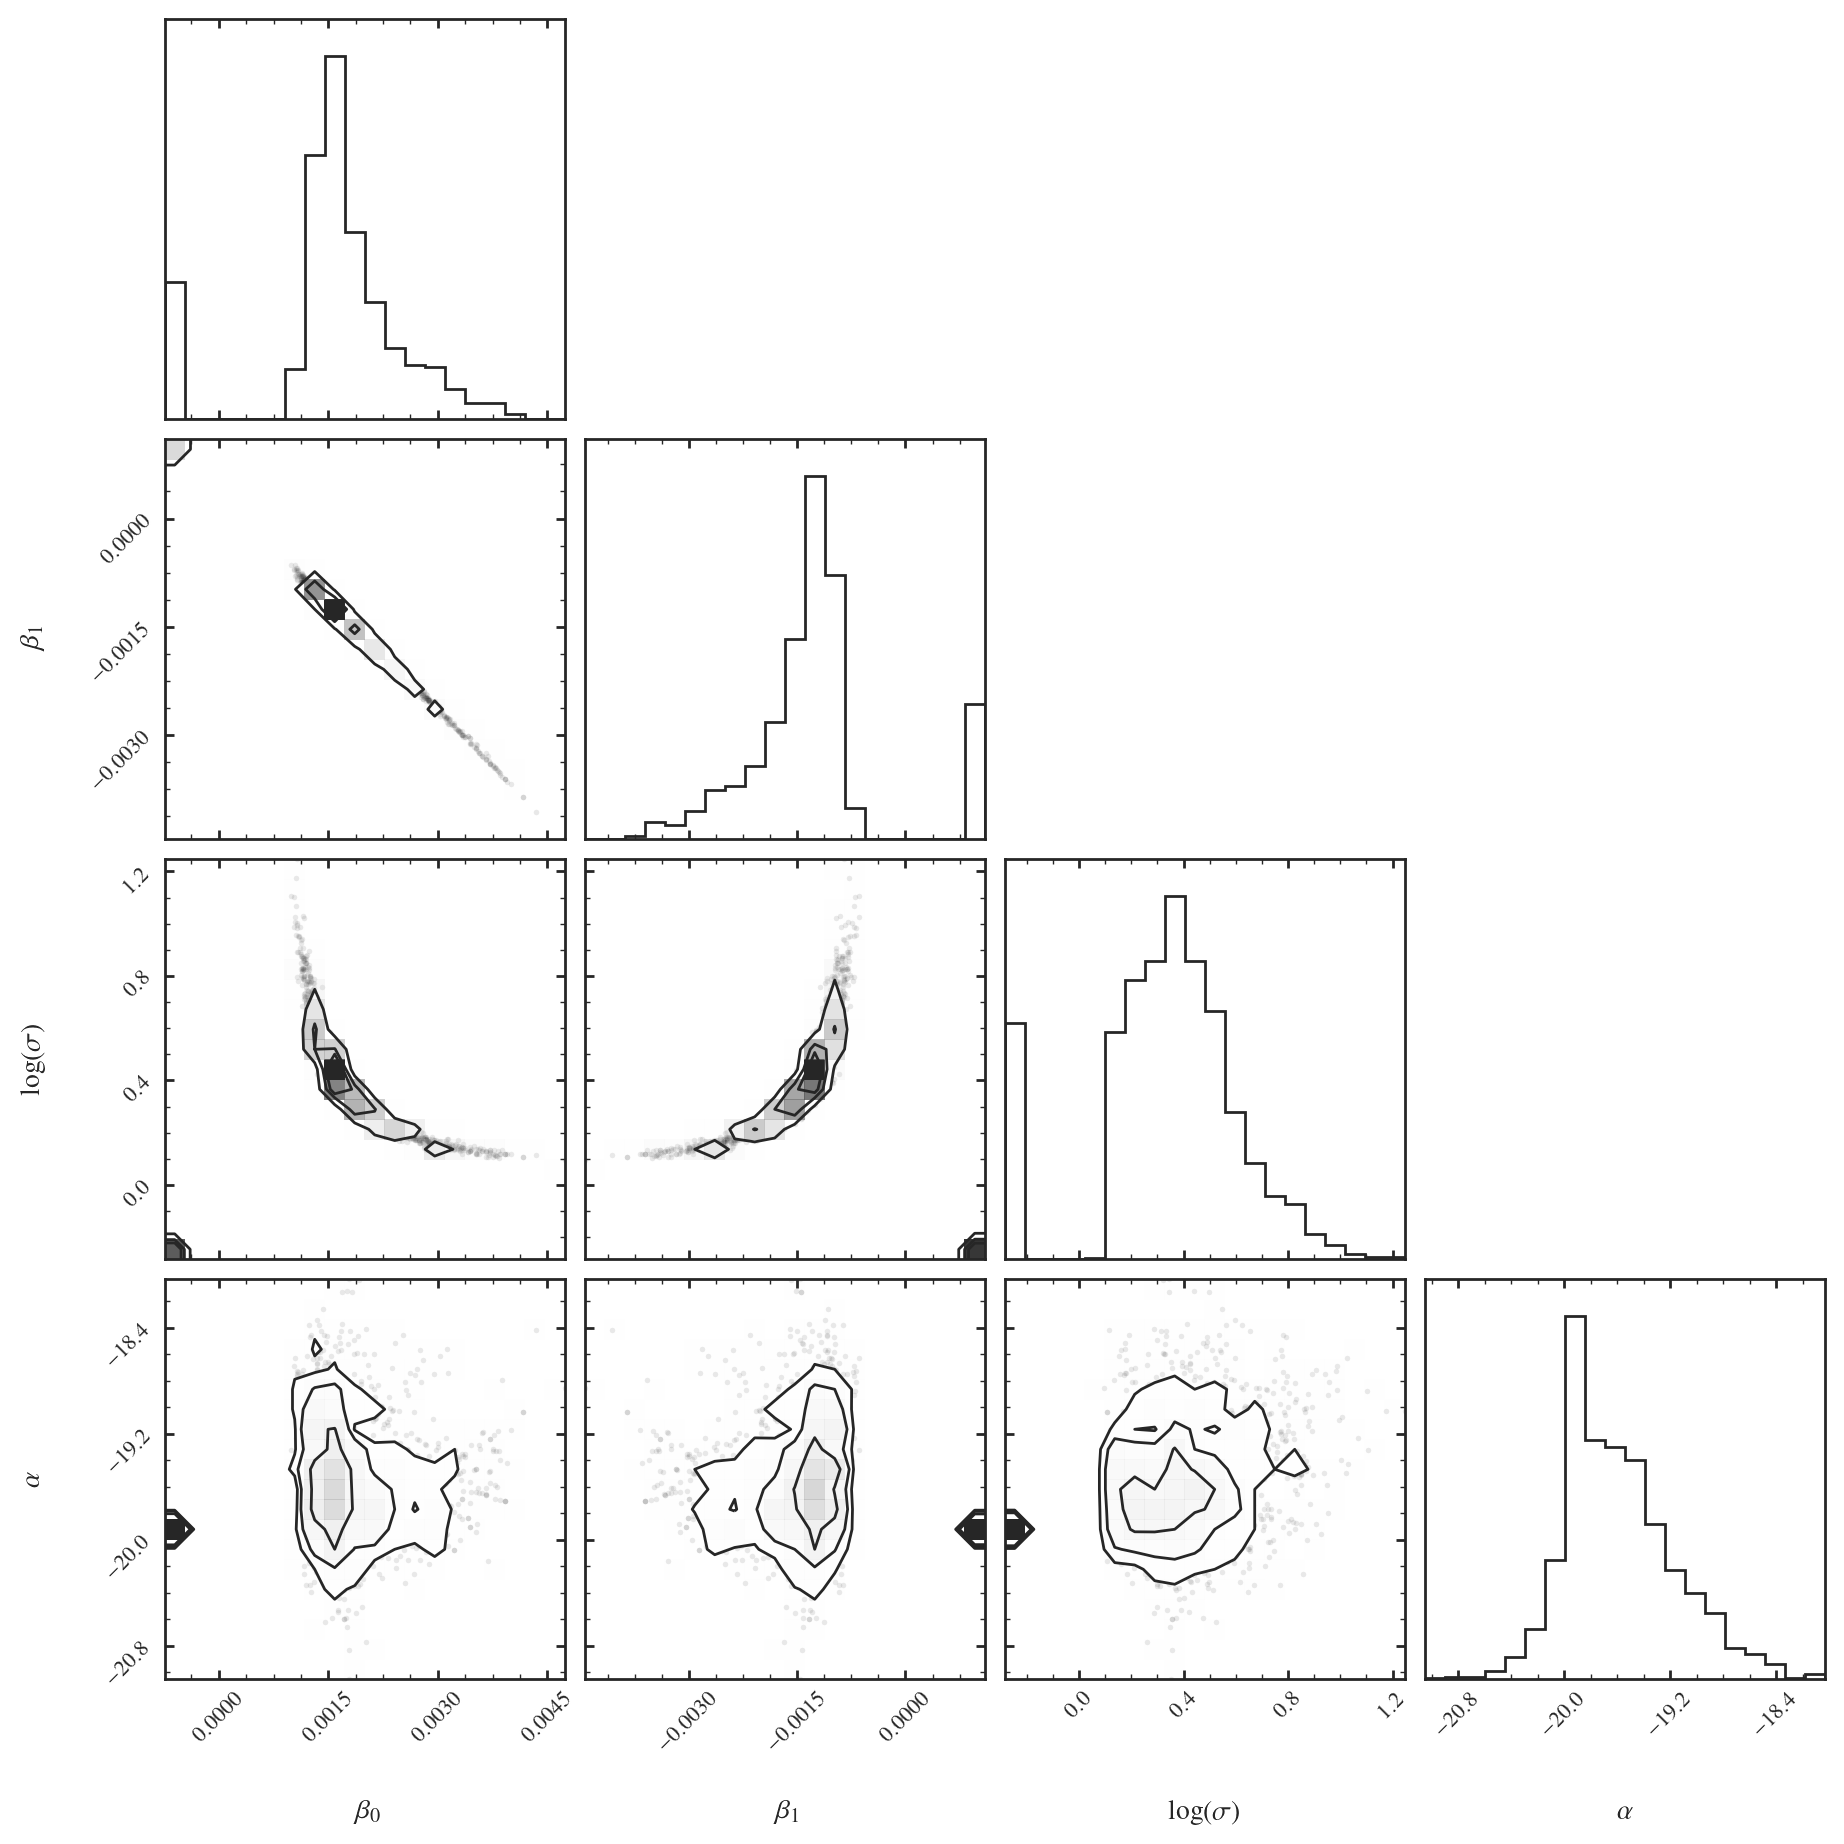

In [35]:
samples = mcmc_utils.run_mcmc(exp_model, obs, N=N, discard=discard)

$\beta_0$ = 1.62e-03 + 3.85e-04 - 7.64e-04
$\beta_1$ = -1.29e-03 + 7.43e-04 - 3.68e-04
$\log(\sigma)$ = 3.58e-01 + 2.07e-01 - 2.10e-01
$\alpha$ = -1.96e+01 + 2.90e-01 - 4.74e-01
1.658e-03  ±  5.397e-04
-1.329e-03  ±  5.214e-04
3.925e-01  ±  2.335e-01


(-0.001, 0.002)

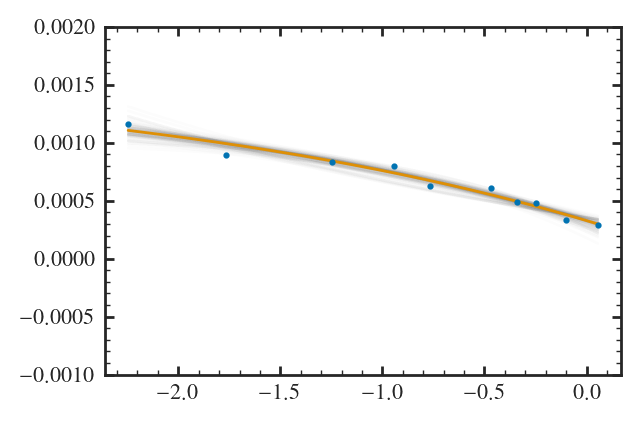

In [36]:
mcmc_utils.plot_posterior(exp_model, obs, samples)
fit_ls(obs, exp_ls)
plt.ylim(-1e-3, 2e-3)

# V13

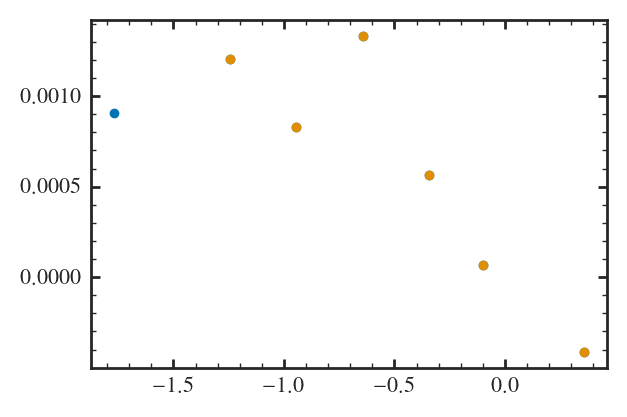

In [37]:
obs = get_yield_table("ventura13")

plt.scatter(obs[0], obs[1])
obs = list(obs)
obs[0] = obs[0][1:]
obs[1] = obs[1][1:]
plt.scatter(obs[0], obs[1])


100%|████████████████████████████████████████████| 3000/3000 [00:11<00:00, 251.09it/s]


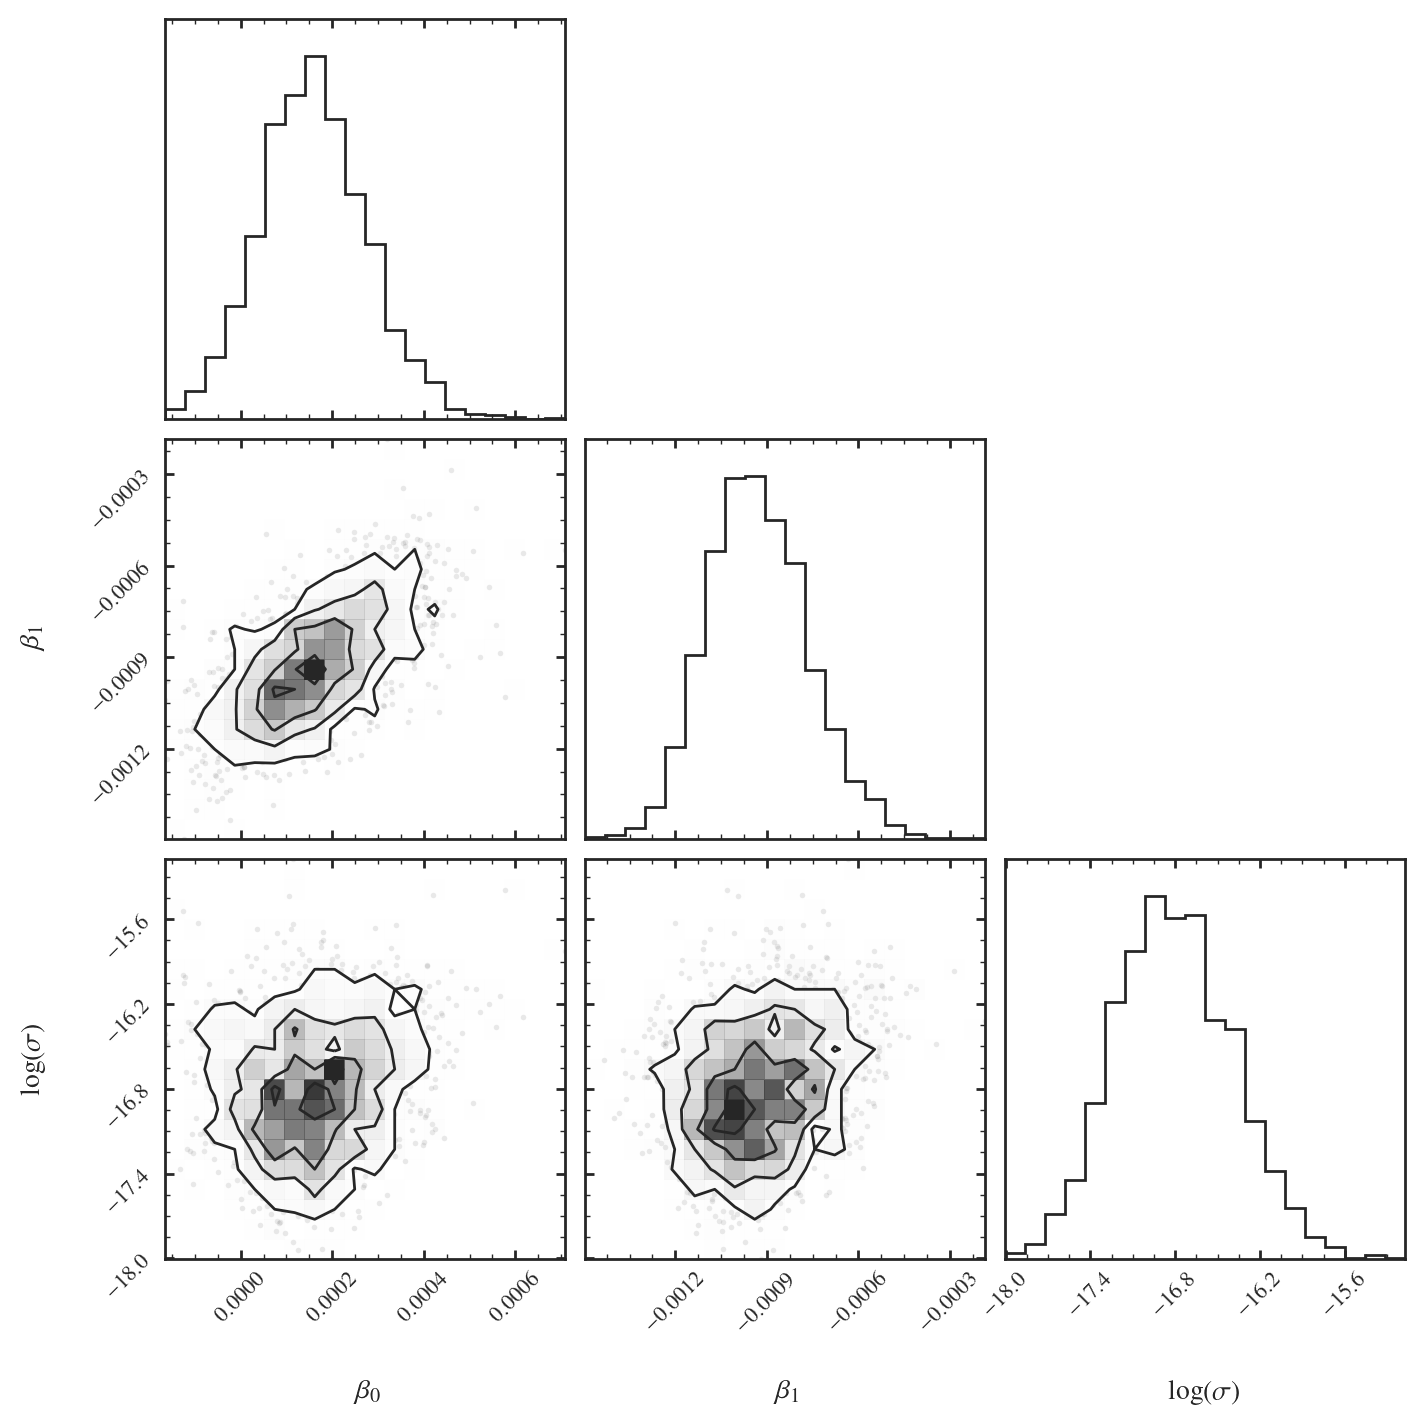

In [38]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 1.55e-04 + 1.07e-04 - 1.18e-04
$\beta_1$ = -9.37e-04 + 1.53e-04 - 1.69e-04
$\log(\sigma)$ = -1.68e+01 + 3.92e-01 - 4.38e-01
9.563e-05  ±  1.896e-04
-1.030e-03  ±  2.632e-04


array([ 9.56292200e-05, -1.03032058e-03])

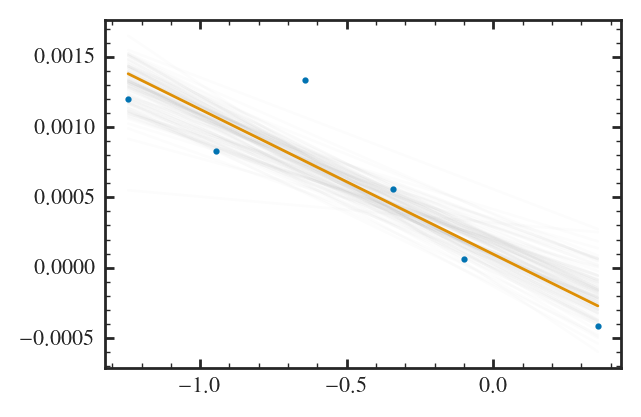

In [39]:
mcmc_utils.plot_posterior(lin_model, obs, samples)
fit_ls(obs, lin_ls)


100%|████████████████████████████████████████████| 3000/3000 [00:14<00:00, 203.01it/s]


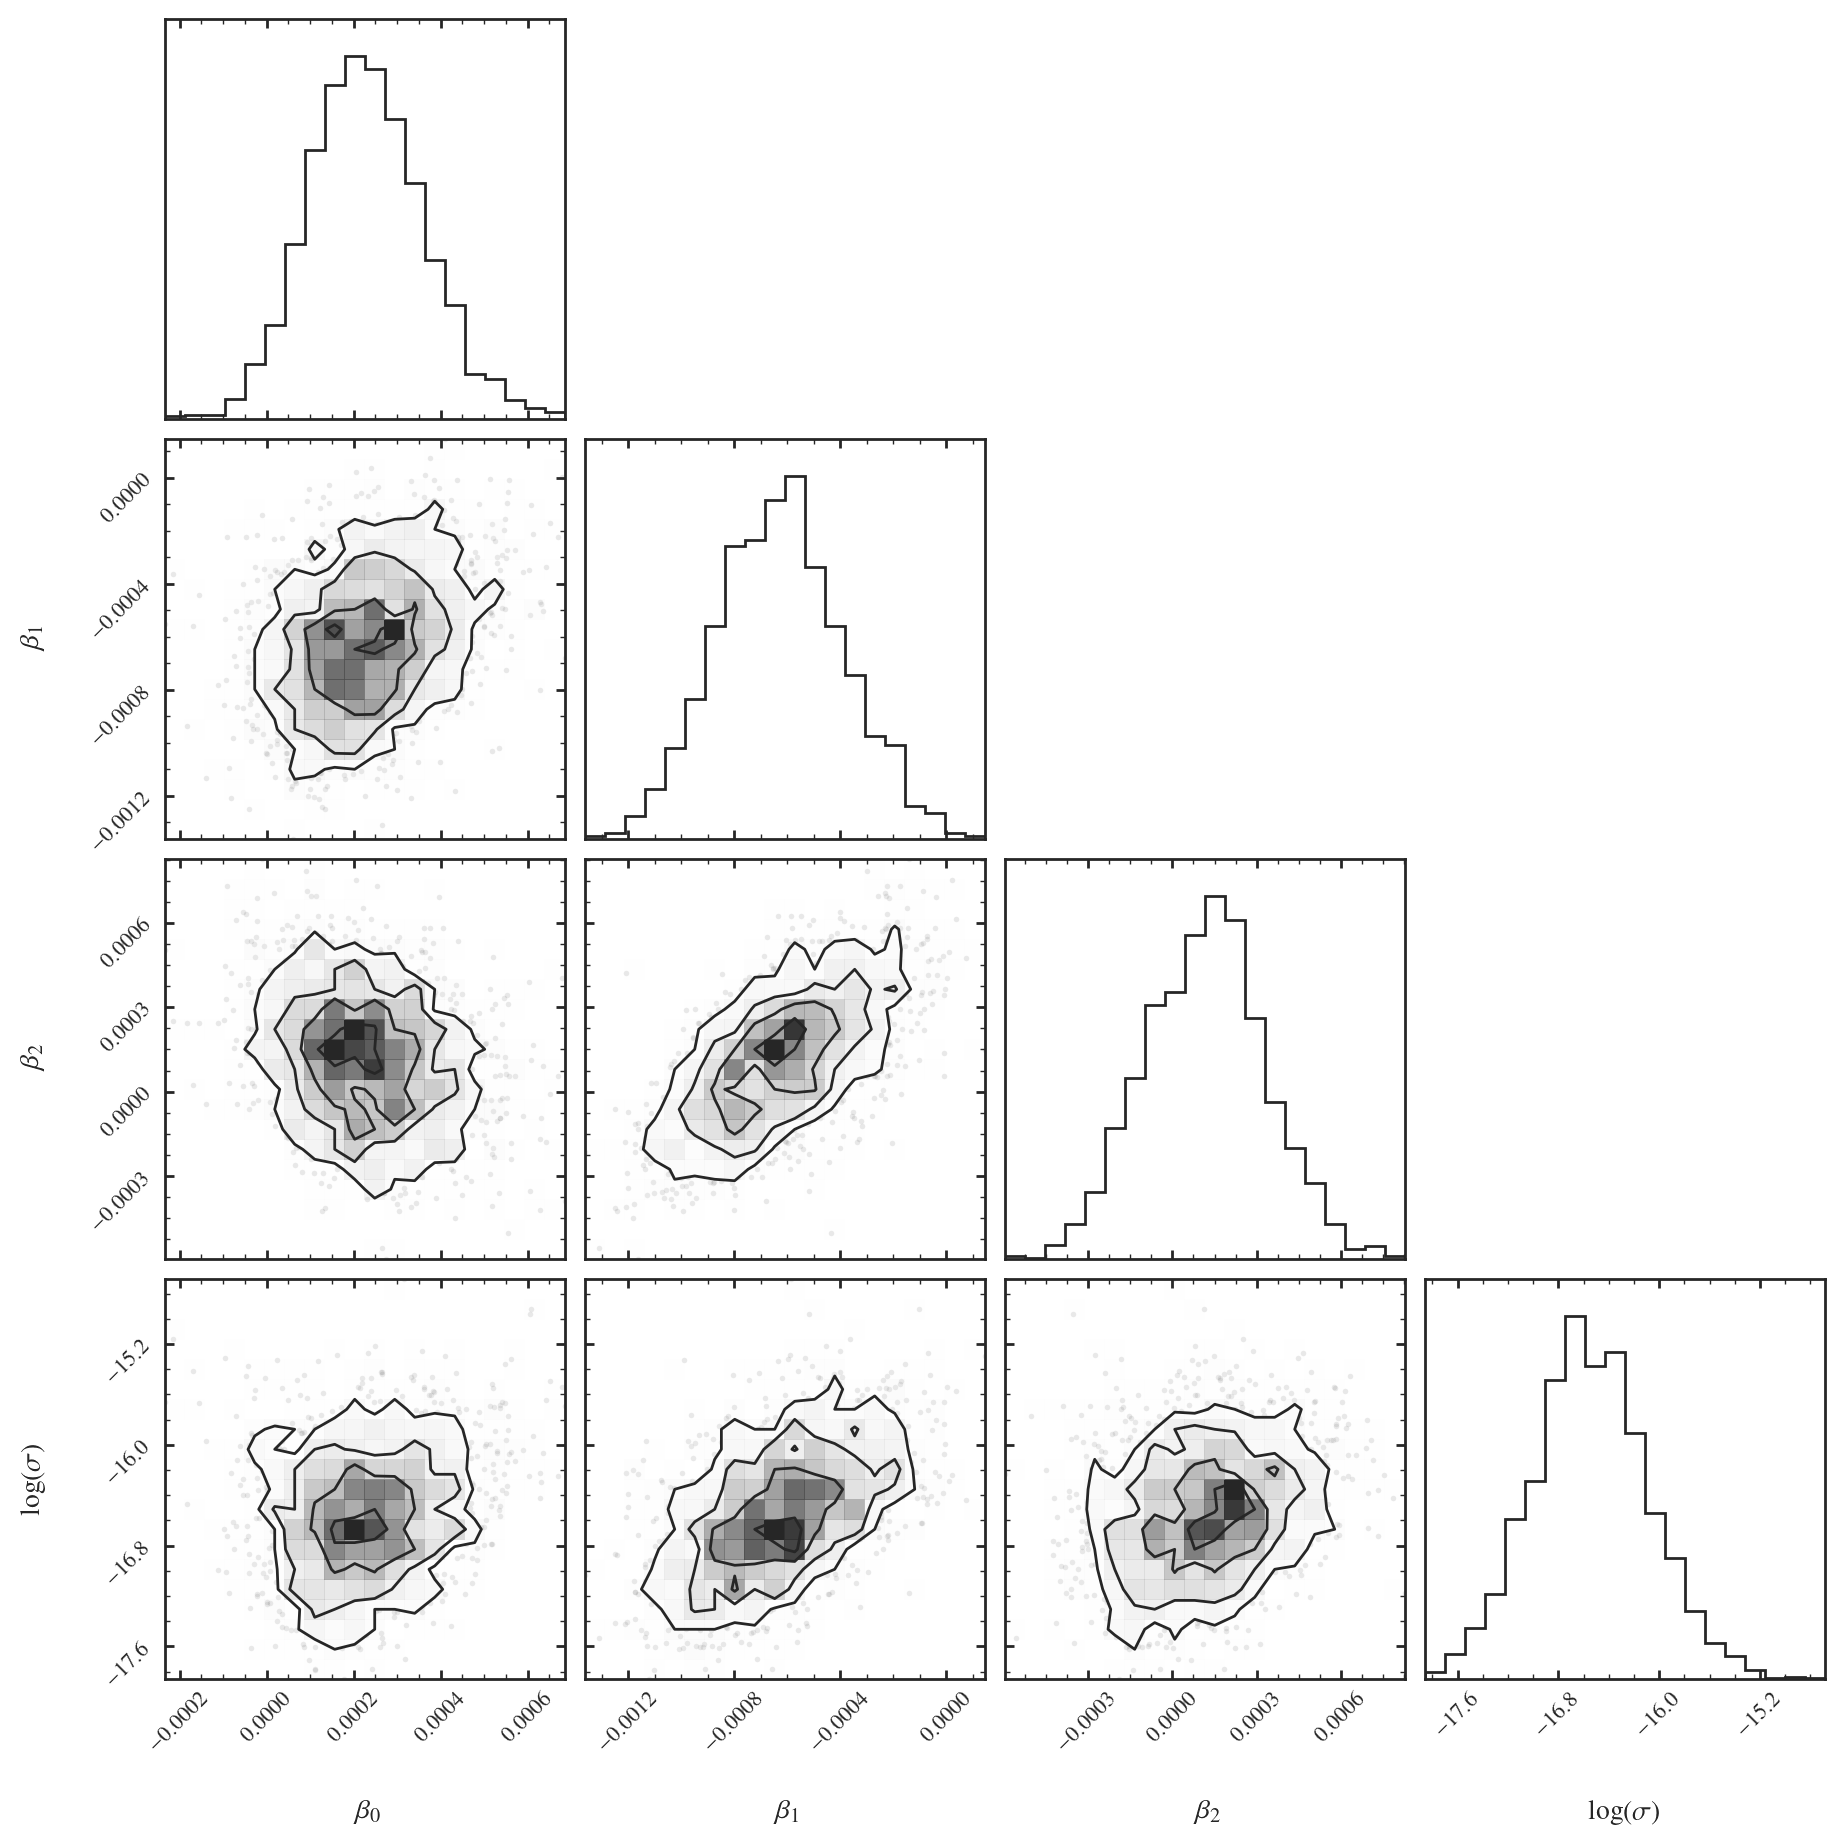

In [40]:
samples = mcmc_utils.run_mcmc(quad_model, obs, N=N, discard=discard)

$\beta_0$ = 2.24e-04 + 1.26e-04 - 1.37e-04
$\beta_1$ = -6.29e-04 + 2.33e-04 - 2.42e-04
$\beta_2$ = 1.21e-04 + 2.23e-04 - 2.04e-04
$\log(\sigma)$ = -1.66e+01 + 4.49e-01 - 4.72e-01
1.447e-04  ±  1.835e-04
-1.579e-03  ±  5.141e-04
-6.090e-04  ±  4.998e-04


array([ 0.00014473, -0.00157866, -0.00060902])

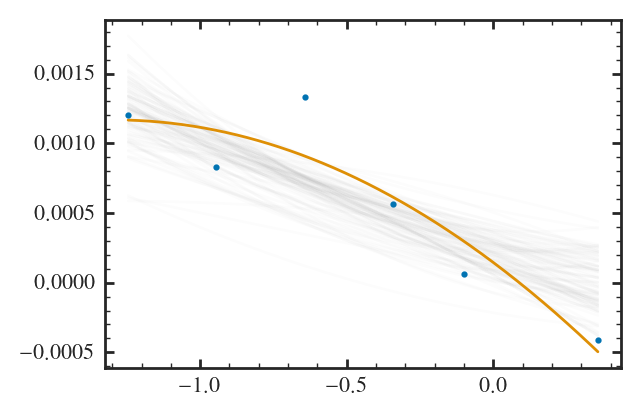

In [41]:
mcmc_utils.plot_posterior(quad_model, obs, samples)
fit_ls(obs, quad_ls)


100%|████████████████████████████████████████████| 3000/3000 [00:15<00:00, 198.37it/s]


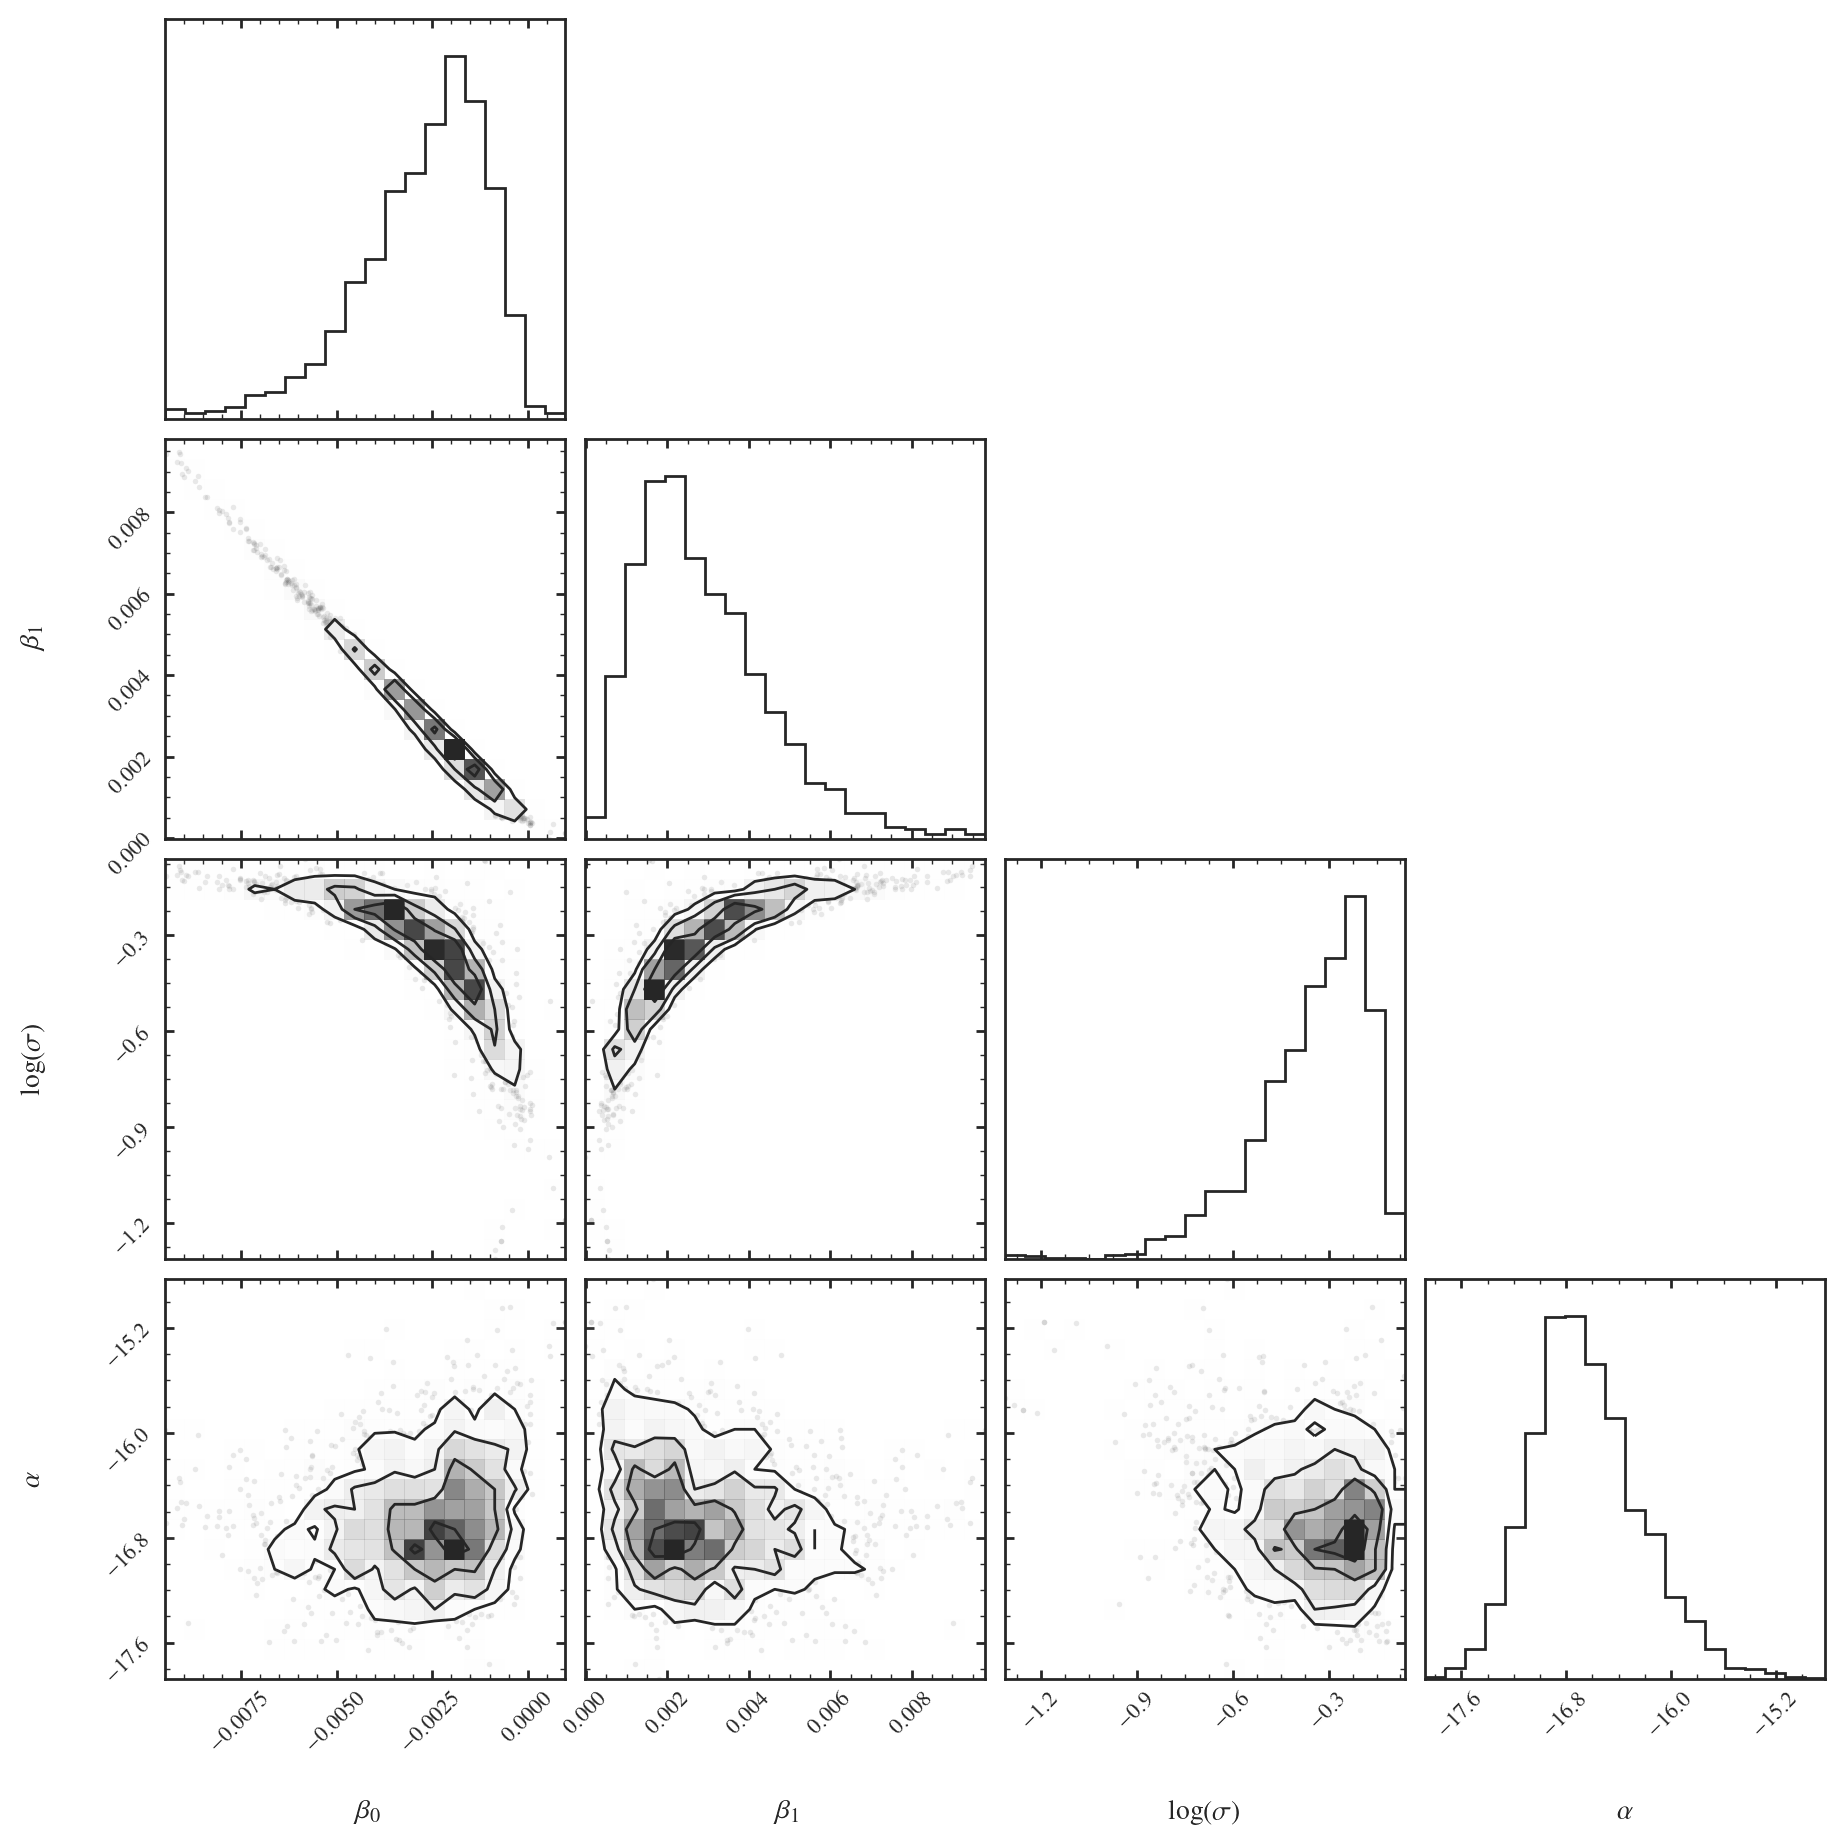

In [42]:
samples = mcmc_utils.run_mcmc(exp_model, obs, N=N, discard=discard)

$\beta_0$ = -2.45e-03 + 1.96e-03 - 1.28e-03
$\beta_1$ = 2.57e-03 + 1.23e-03 - 1.92e-03
$\log(\sigma)$ = -3.19e-01 + 2.04e-01 - 1.28e-01
$\alpha$ = -1.67e+01 + 3.57e-01 - 4.59e-01
1.653e-03  ±  1.152e-03
-1.492e-03  ±  1.293e-03
9.974e-01  ±  1.065e+00


(-0.001, 0.002)

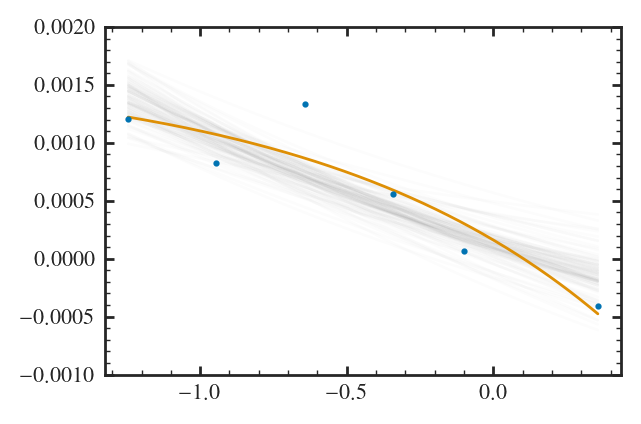

In [43]:
mcmc_utils.plot_posterior(exp_model, obs, samples)
fit_ls(obs, exp_ls)

plt.ylim(-1e-3, 2e-3)

# K16

In [44]:
obs = get_yield_table("karakas16")

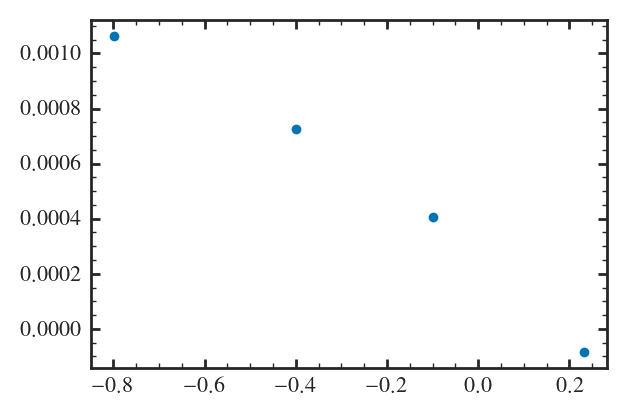

In [45]:
plt.scatter(obs[0], obs[1])

100%|████████████████████████████████████████████| 3000/3000 [00:11<00:00, 255.60it/s]


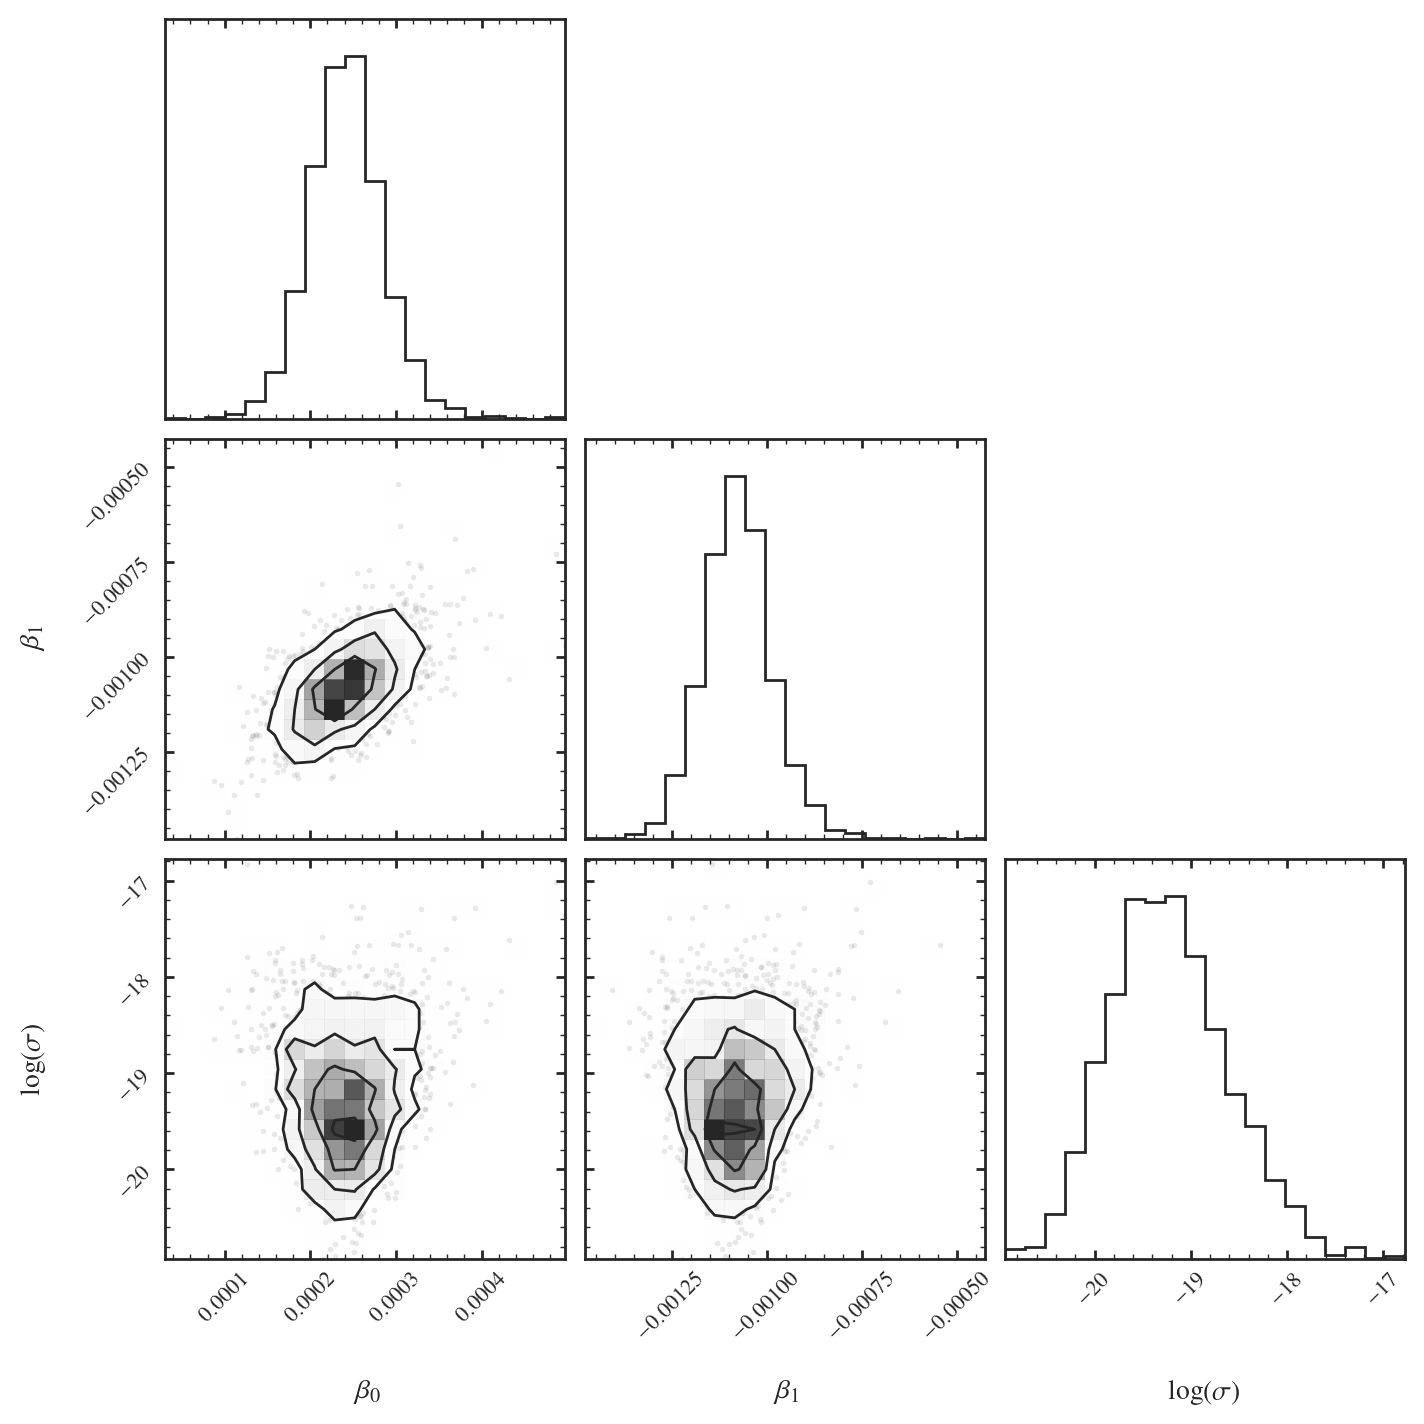

In [46]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 2.41e-04 + 4.01e-05 - 4.05e-05
$\beta_1$ = -1.08e-03 + 8.60e-05 - 8.34e-05
$\log(\sigma)$ = -1.93e+01 + 5.56e-01 - 6.57e-01
2.338e-04  ±  4.869e-05
-1.103e-03  ±  1.049e-04


array([ 0.00023381, -0.00110348])

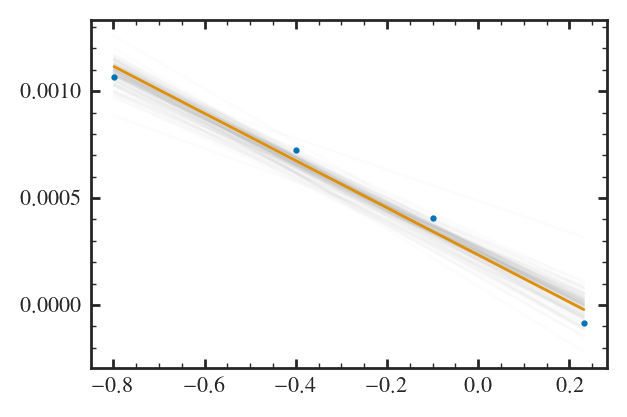

In [47]:
mcmc_utils.plot_posterior(lin_model, obs, samples)
fit_ls(obs, lin_ls)


100%|████████████████████████████████████████████| 3000/3000 [00:15<00:00, 197.52it/s]


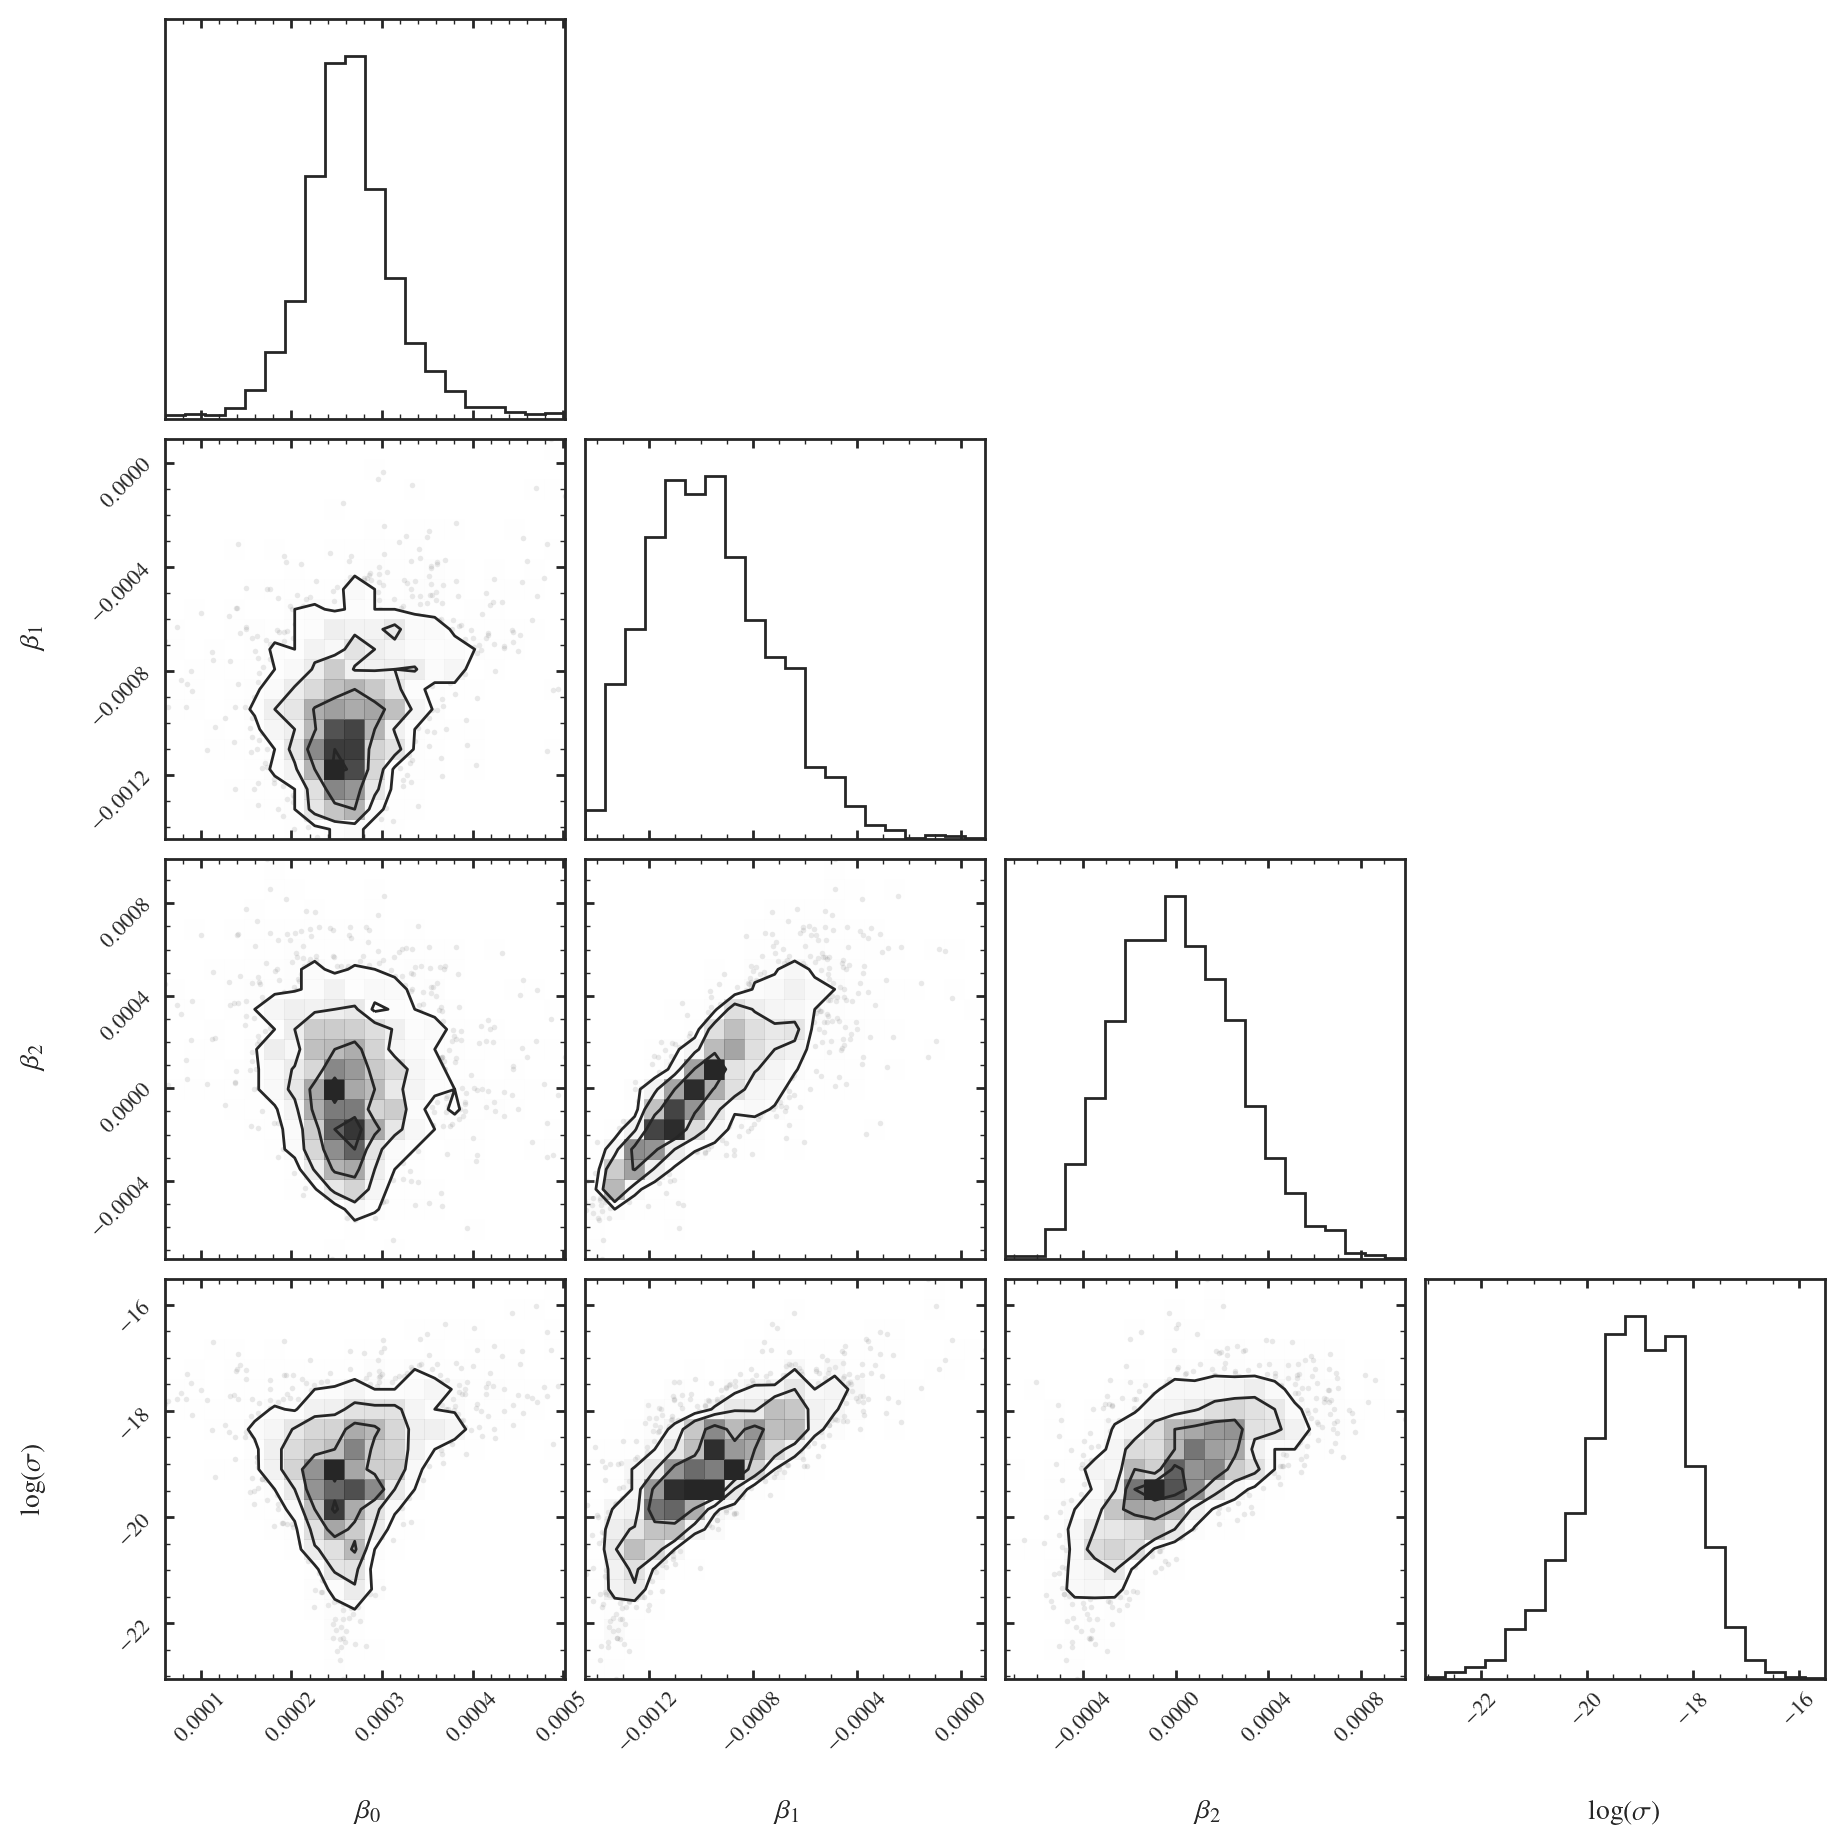

In [48]:
samples = mcmc_utils.run_mcmc(quad_model, obs, N=N, discard=discard)

$\beta_0$ = 2.62e-04 + 4.30e-05 - 4.88e-05
$\beta_1$ = -9.83e-04 + 2.18e-04 - 2.74e-04
$\beta_2$ = 7.60e-06 + 2.59e-04 - 2.71e-04
$\log(\sigma)$ = -1.91e+01 + 1.08e+00 - 9.38e-01
2.623e-04  ±  1.099e-05
-1.369e-03  ±  4.513e-05
-4.611e-04  ±  6.862e-05


array([ 0.00026233, -0.00136885, -0.00046112])

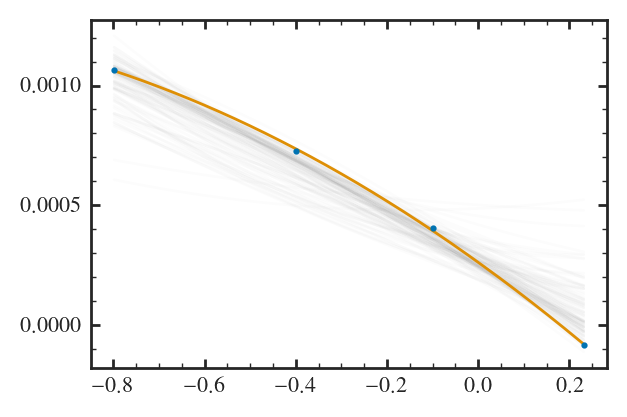

In [49]:
mcmc_utils.plot_posterior(quad_model, obs, samples)
fit_ls(obs, quad_ls)


100%|████████████████████████████████████████████| 3000/3000 [00:14<00:00, 200.82it/s]


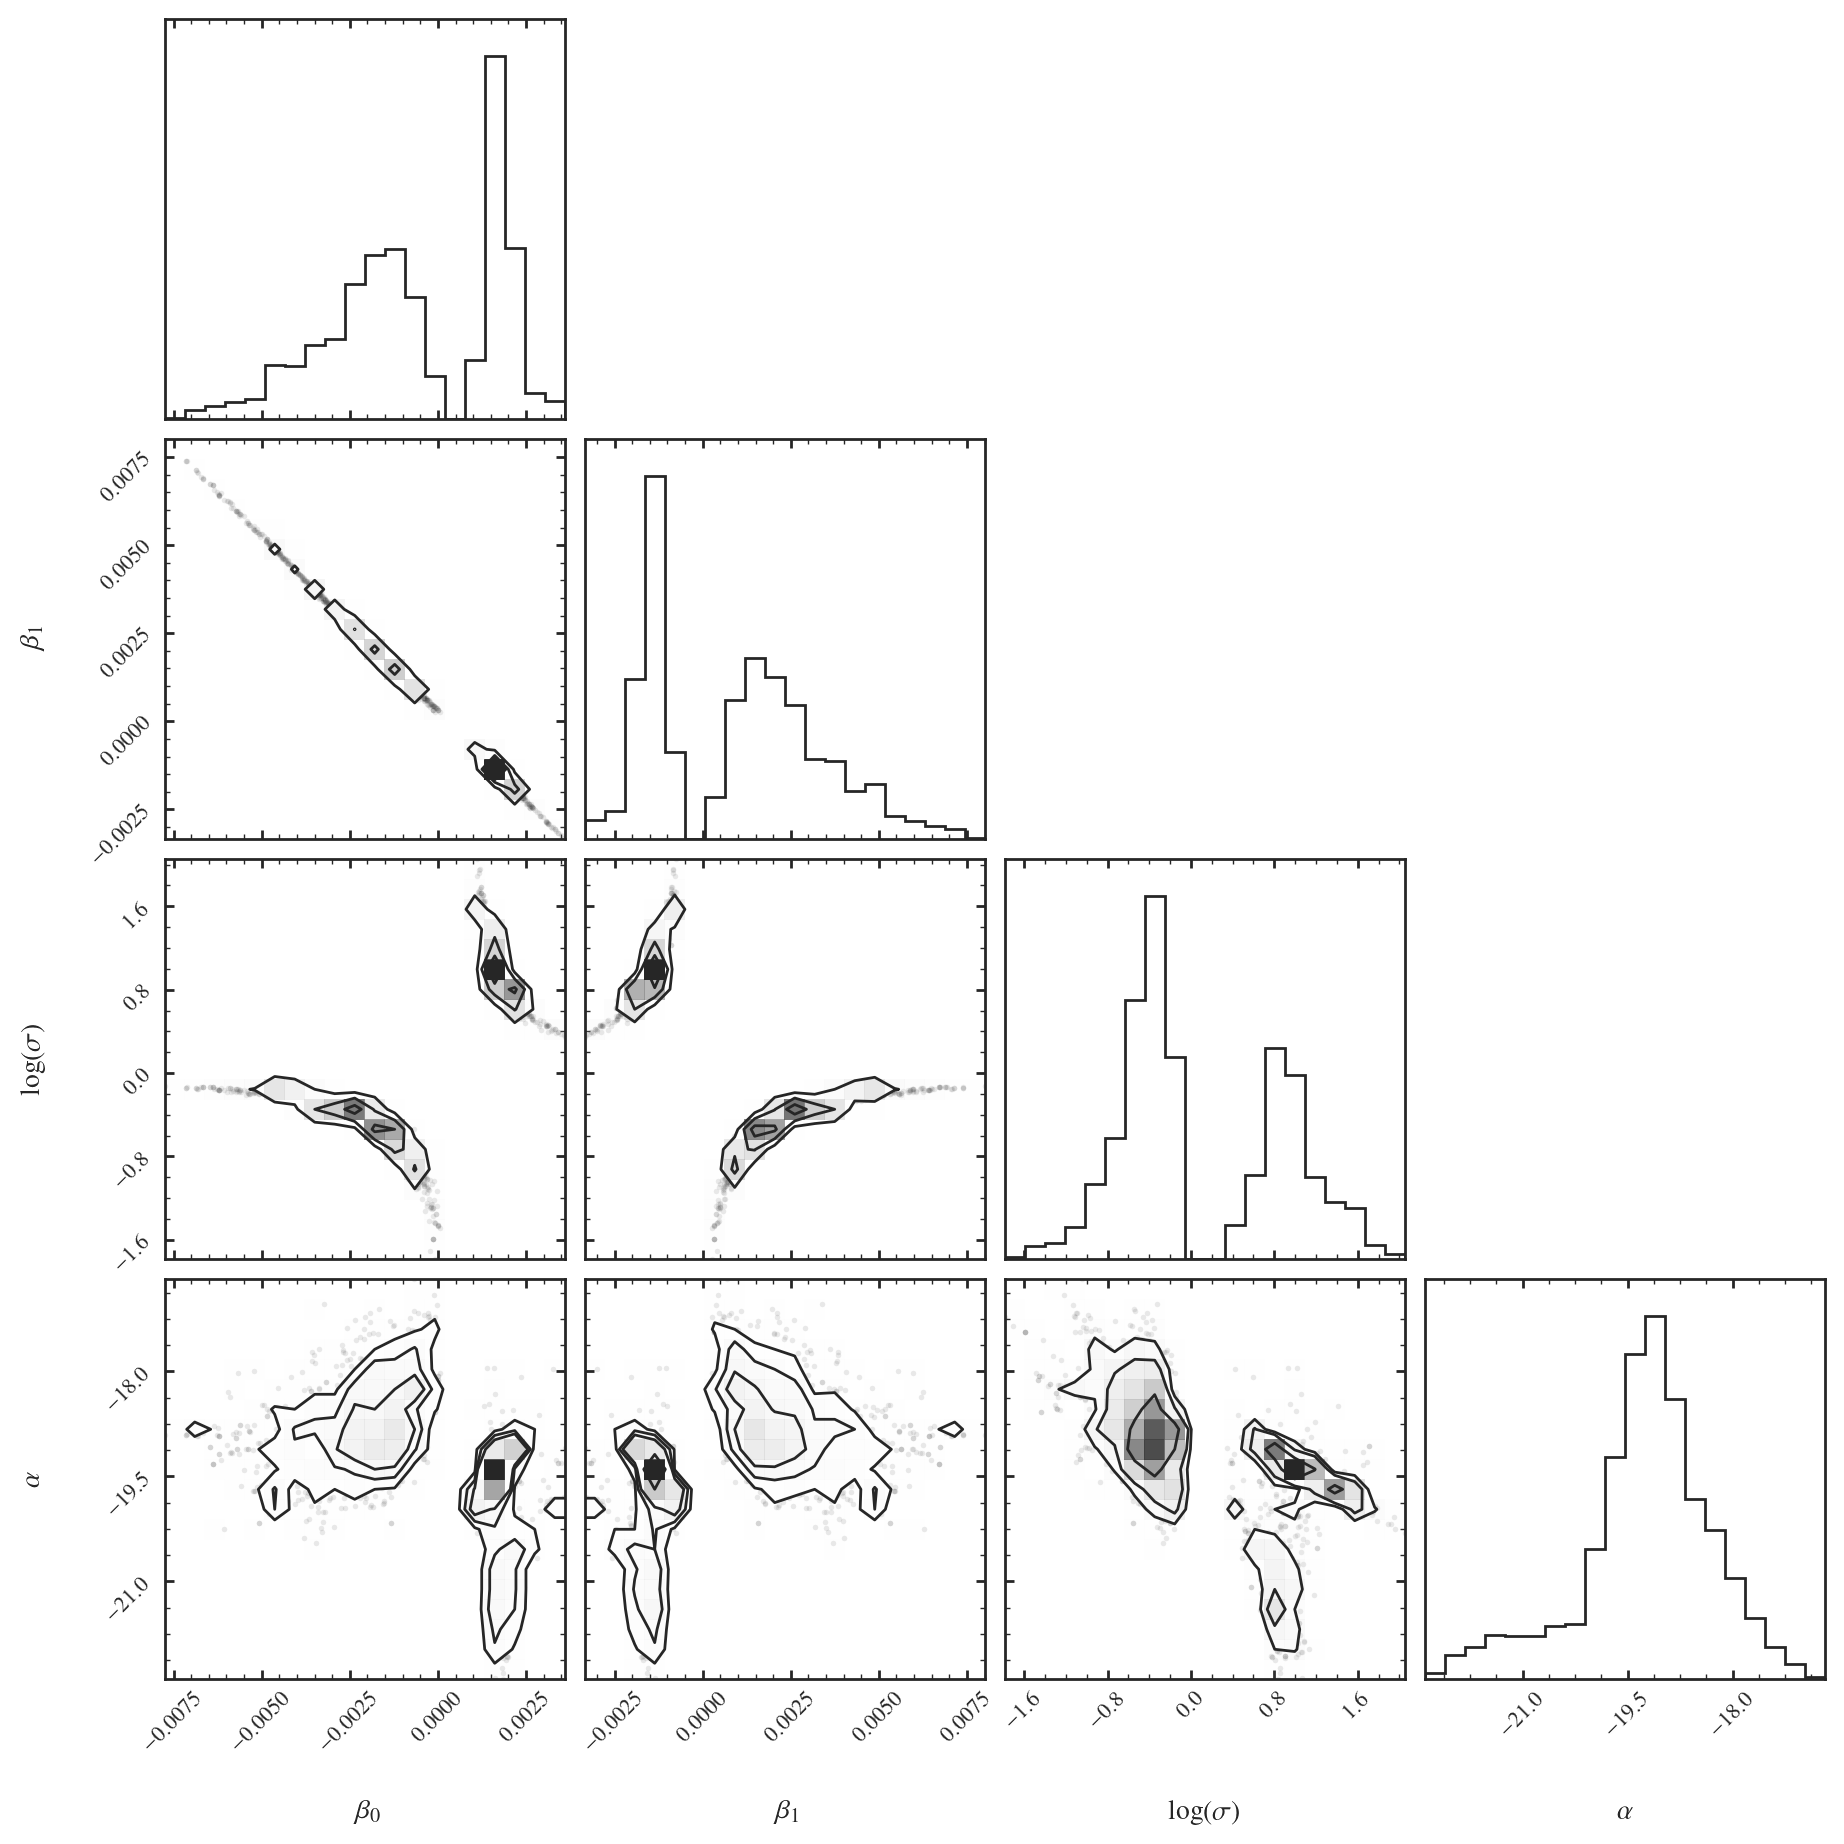

In [50]:
samples = mcmc_utils.run_mcmc(exp_model, obs, N=N, discard=discard)

$\beta_0$ = -9.09e-04 + 2.22e-03 - 2.75e-03
$\beta_1$ = 1.13e-03 + 2.69e-03 - 2.24e-03
$\log(\sigma)$ = -2.43e-01 + 3.58e-01 - 1.24e+00
$\alpha$ = -1.92e+01 + 7.84e-01 - 8.15e-01
1.880e-03  ±  1.203e-04
-1.612e-03  ±  1.247e-04
8.487e-01  ±  7.801e-02


(-0.001, 0.002)

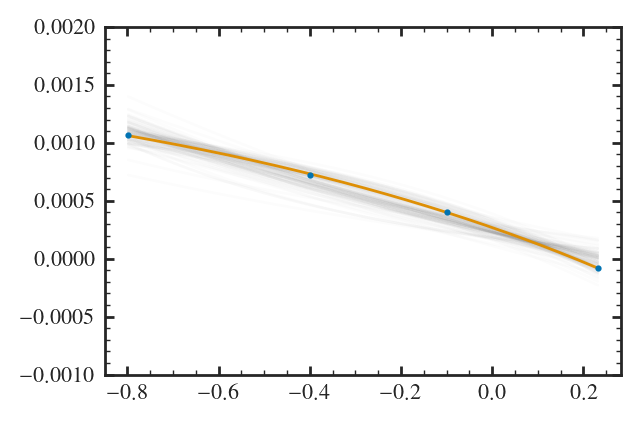

In [51]:
mcmc_utils.plot_posterior(exp_model, obs, samples)
fit_ls(obs, exp_ls)

plt.ylim(-1e-3, 2e-3)

# P16

In [52]:
obs = get_yield_table("battino19")

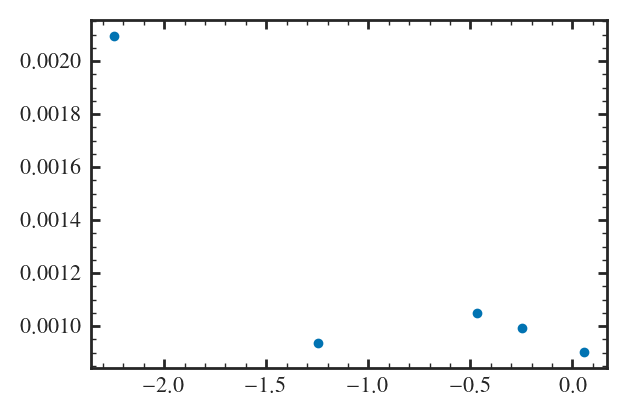

In [53]:
plt.scatter(obs[0], obs[1])

100%|████████████████████████████████████████████| 3000/3000 [00:11<00:00, 259.04it/s]


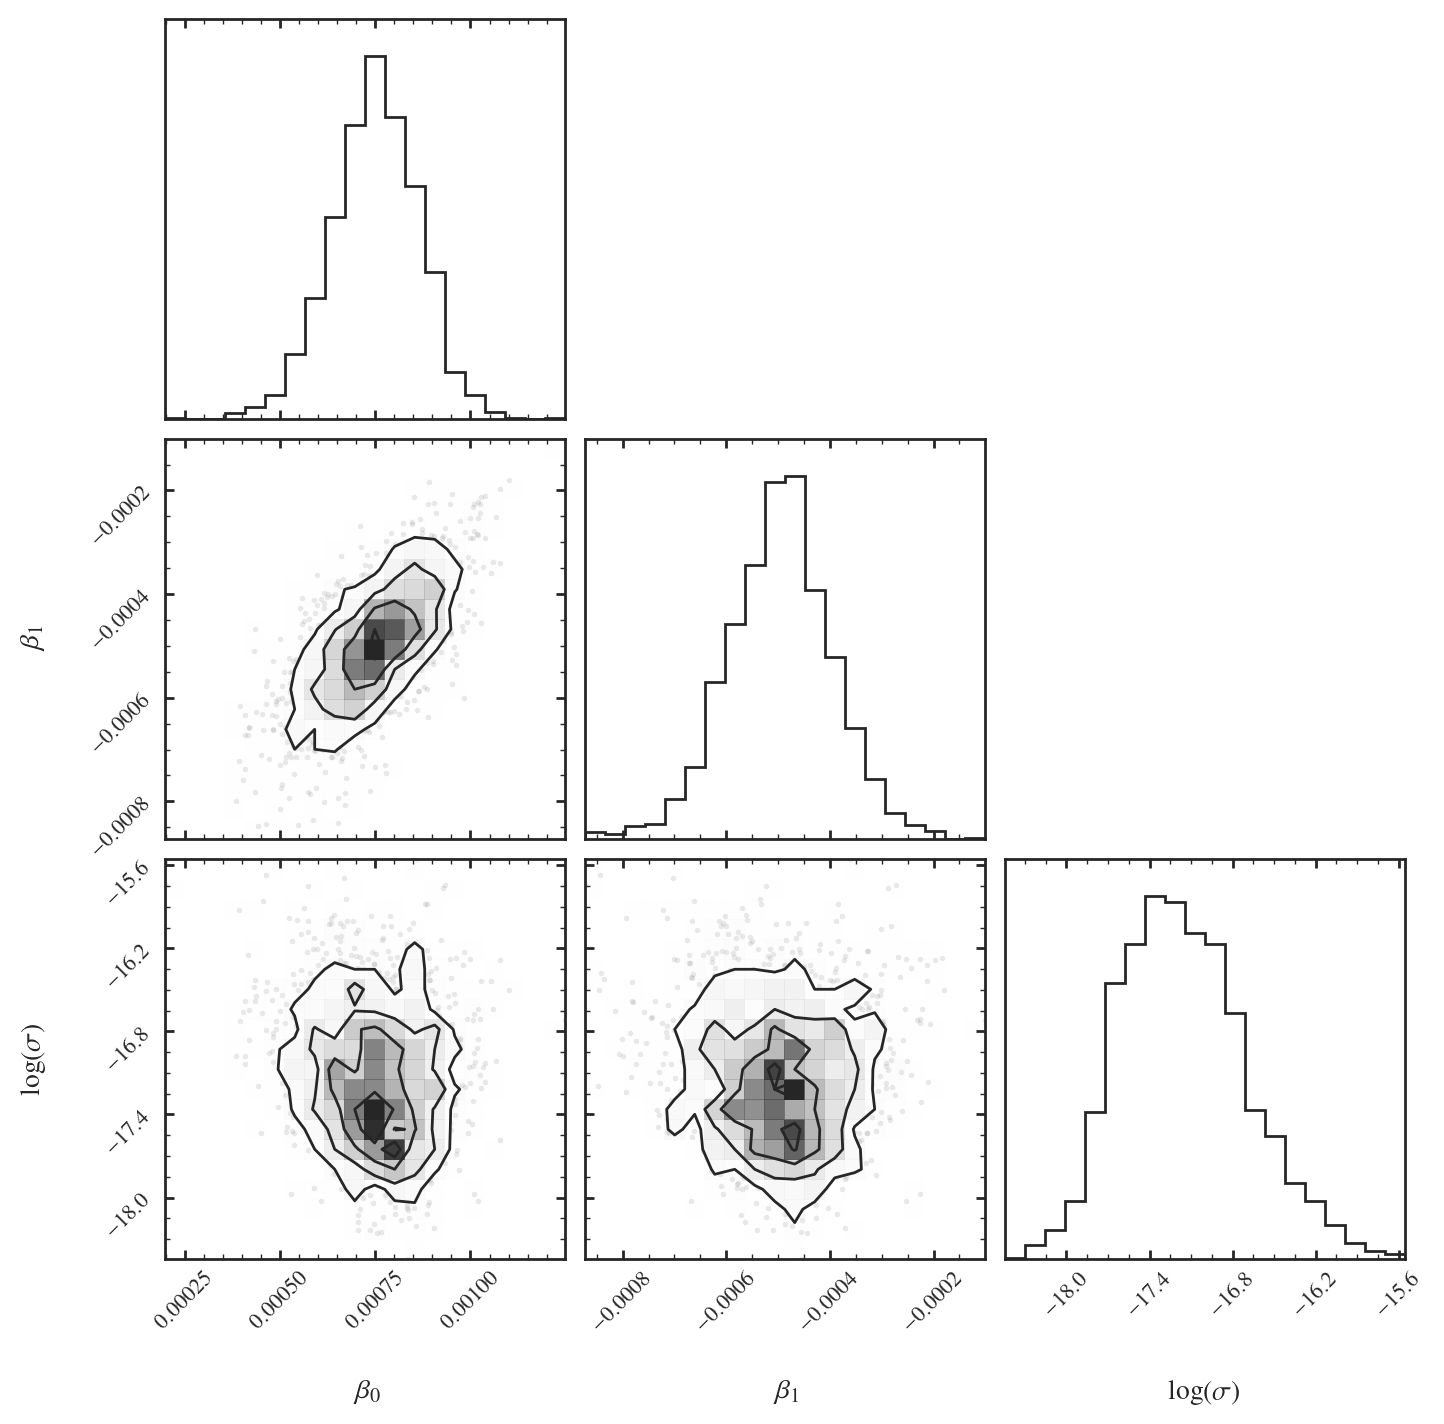

In [54]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 7.50e-04 + 1.09e-04 - 1.12e-04
$\beta_1$ = -4.95e-04 + 9.91e-05 - 9.46e-05
$\log(\sigma)$ = -1.72e+01 + 4.24e-01 - 4.70e-01
8.100e-04  ±  1.945e-04
-4.649e-04  ±  1.659e-04


array([ 0.00081004, -0.00046489])

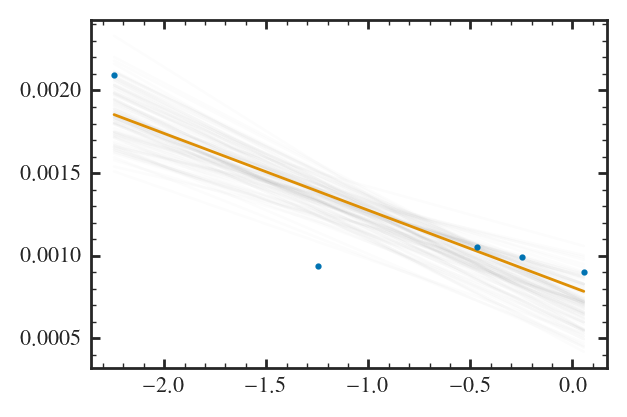

In [55]:
mcmc_utils.plot_posterior(lin_model, obs, samples)
fit_ls(obs, lin_ls)


100%|████████████████████████████████████████████| 3000/3000 [00:14<00:00, 204.89it/s]


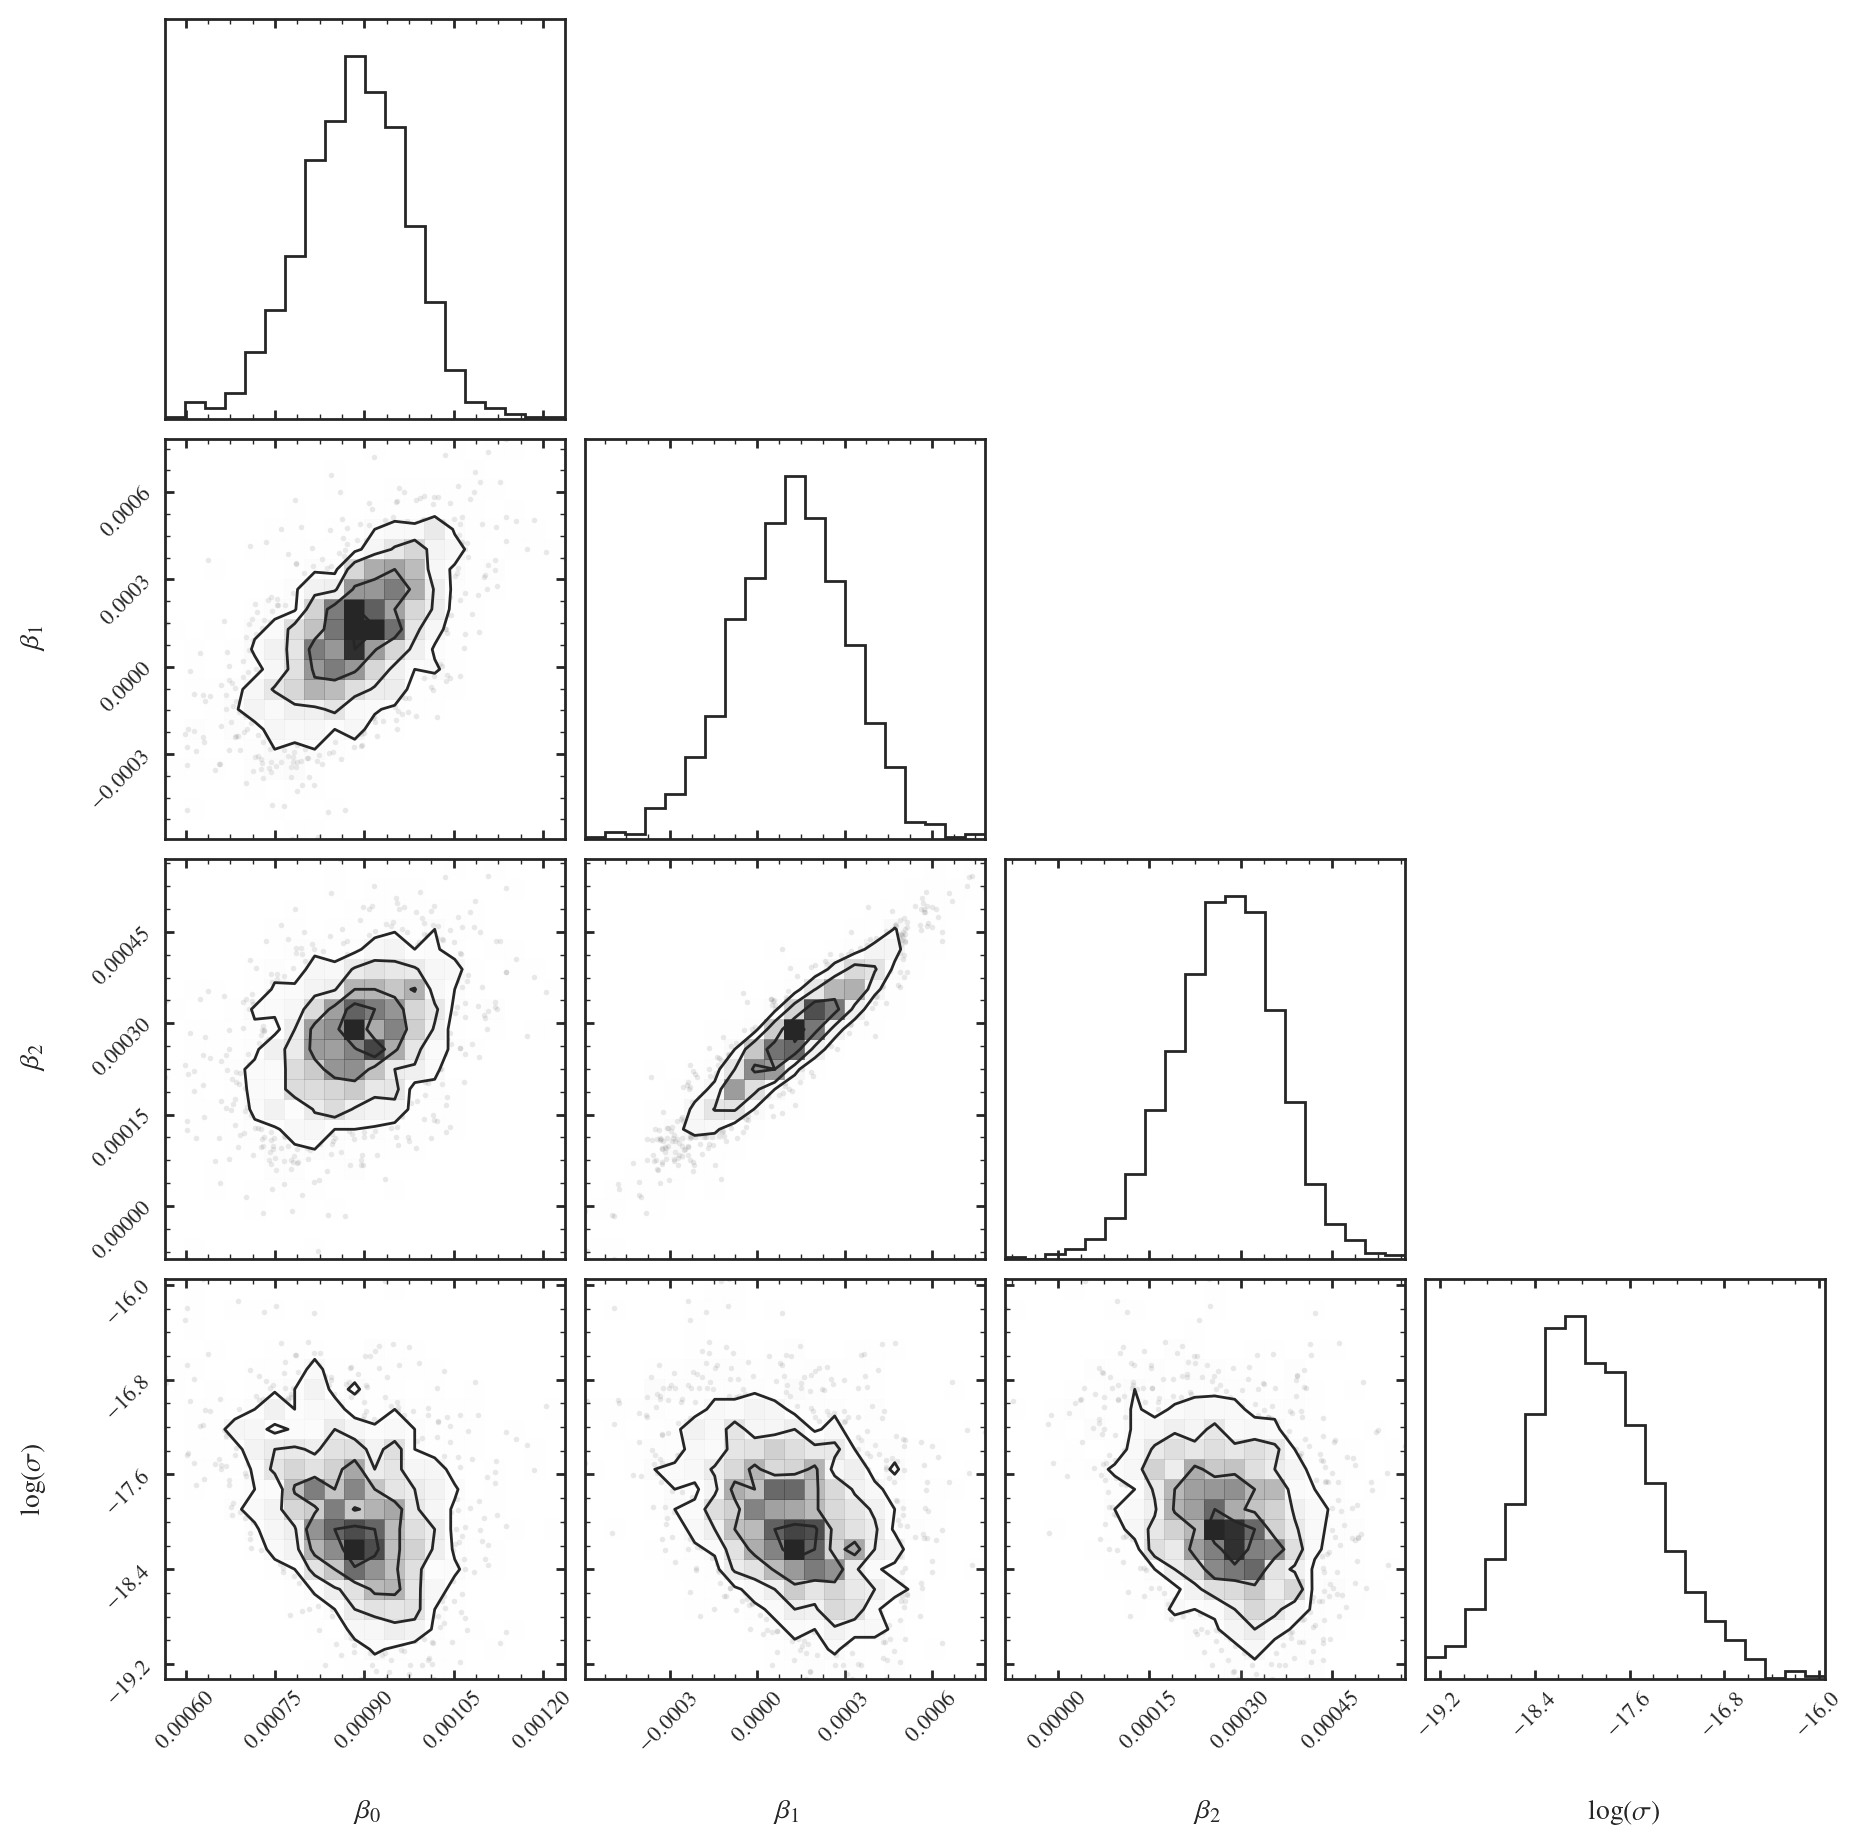

In [56]:
samples = mcmc_utils.run_mcmc(quad_model, obs, N=N, discard=discard)

$\beta_0$ = 8.88e-04 + 9.32e-05 - 8.33e-05
$\beta_1$ = 1.20e-04 + 1.96e-04 - 1.89e-04
$\beta_2$ = 2.78e-04 + 9.02e-05 - 8.02e-05
$\log(\sigma)$ = -1.80e+01 + 4.98e-01 - 5.76e-01
1.002e-03  ±  1.434e-04
4.339e-04  ±  3.830e-04
4.025e-04  ±  1.653e-04


(-0.0003, 0.003)

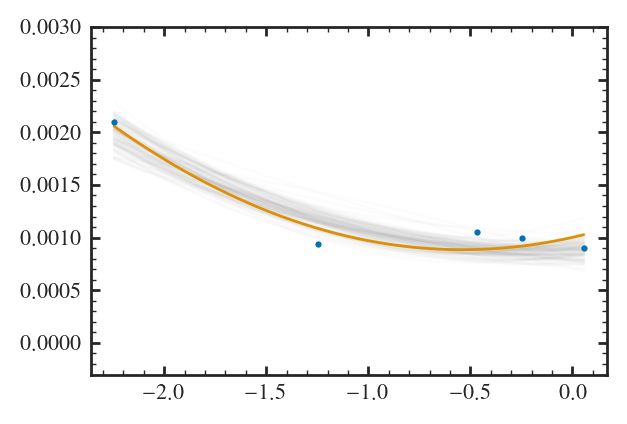

In [57]:
mcmc_utils.plot_posterior(quad_model, obs, samples)
fit_ls(obs, quad_ls)

plt.ylim(-0.3e-3, 3e-3)

100%|████████████████████████████████████████████| 3000/3000 [00:15<00:00, 196.65it/s]


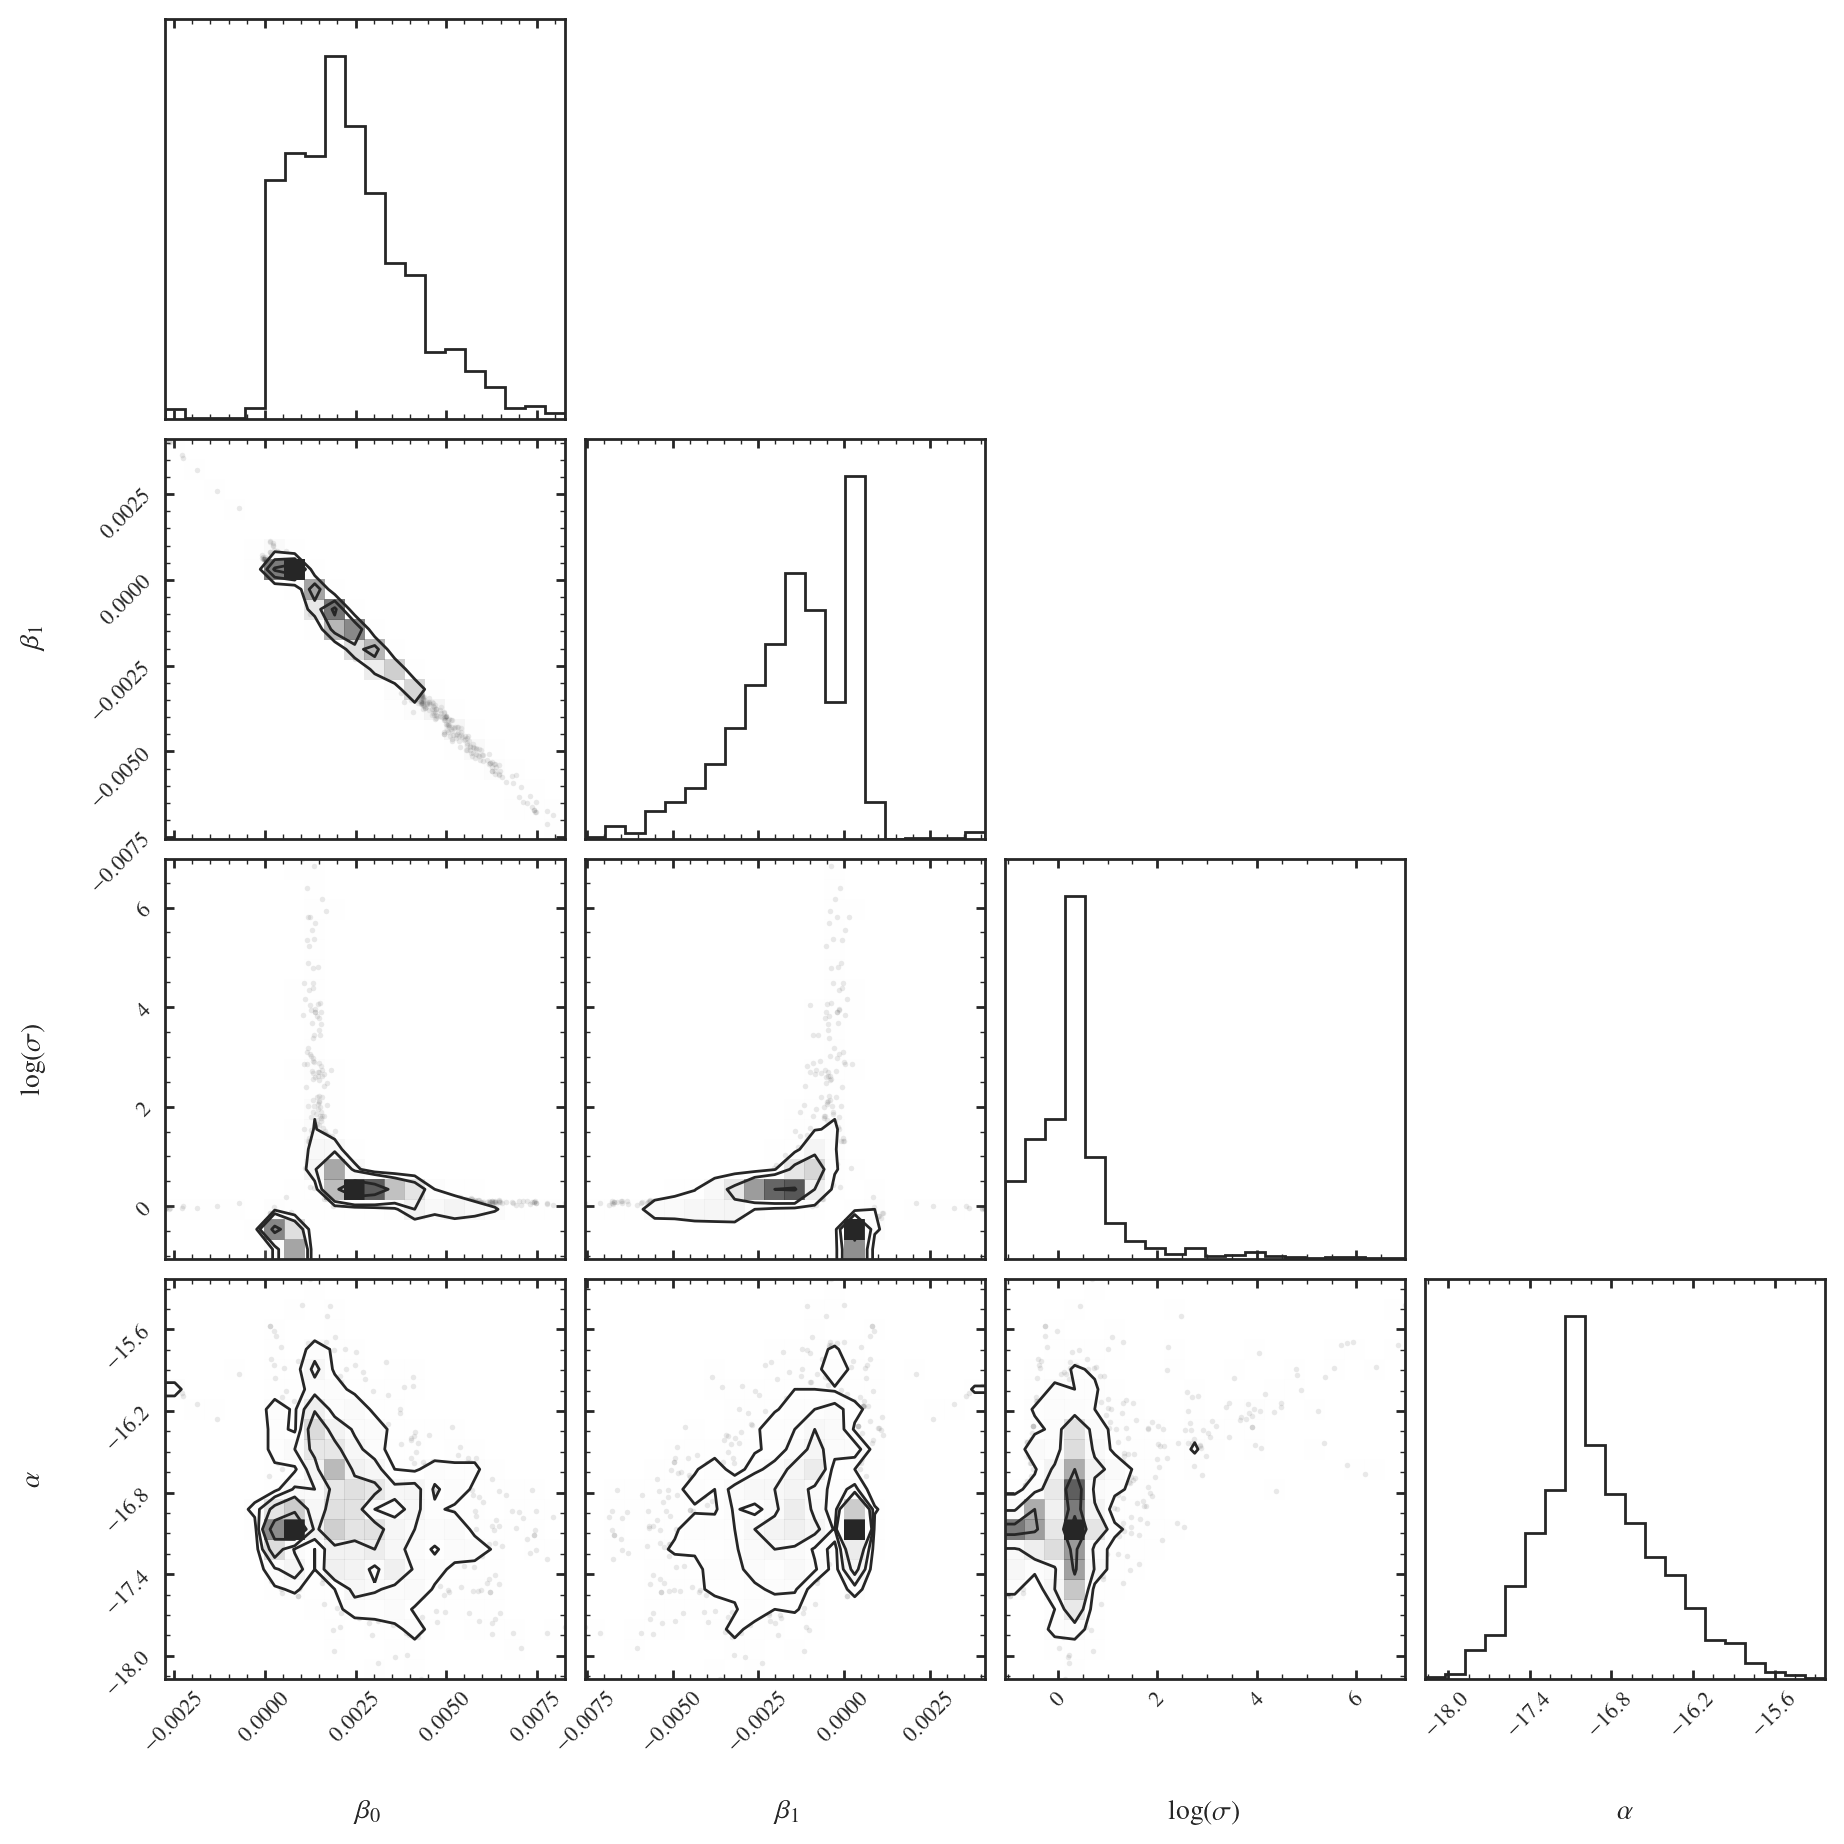

In [58]:
samples = mcmc_utils.run_mcmc(exp_model, obs, N=N, discard=1000)

$\beta_0$ = 2.13e-03 + 1.36e-03 - 1.85e-03
$\beta_1$ = -1.30e-03 + 1.81e-03 - 1.56e-03
$\log(\sigma)$ = 2.14e-01 + 7.97e-01 - 5.40e-01
$\alpha$ = -1.70e+01 + 3.45e-01 - 5.38e-01


(-0.0003, 0.003)

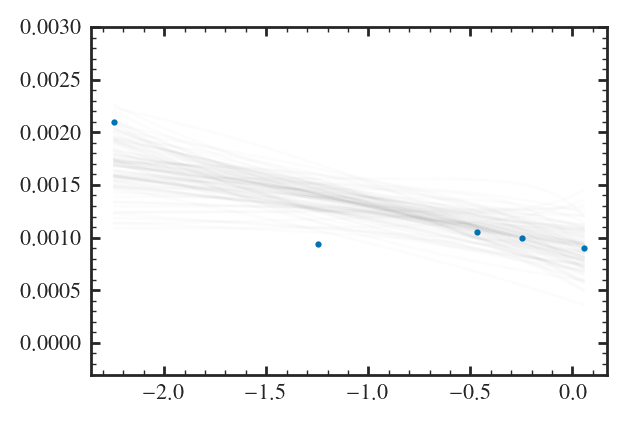

In [59]:
mcmc_utils.plot_posterior(exp_model, obs, samples)
#fit_ls(obs, exp_ls, p0=[3.5e-3, -2.6e-3, -1.79e1])

plt.ylim(-0.3e-3, 3e-3)

In [60]:
obs = get_yield_table("pignatari16")
#obs = (obs[0][1:], obs[1][1:], None, None)

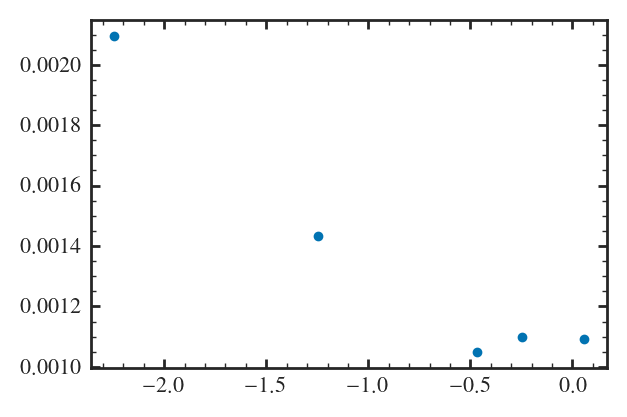

In [61]:
plt.scatter(obs[0], obs[1])

100%|████████████████████████████████████████████| 3000/3000 [00:12<00:00, 244.03it/s]


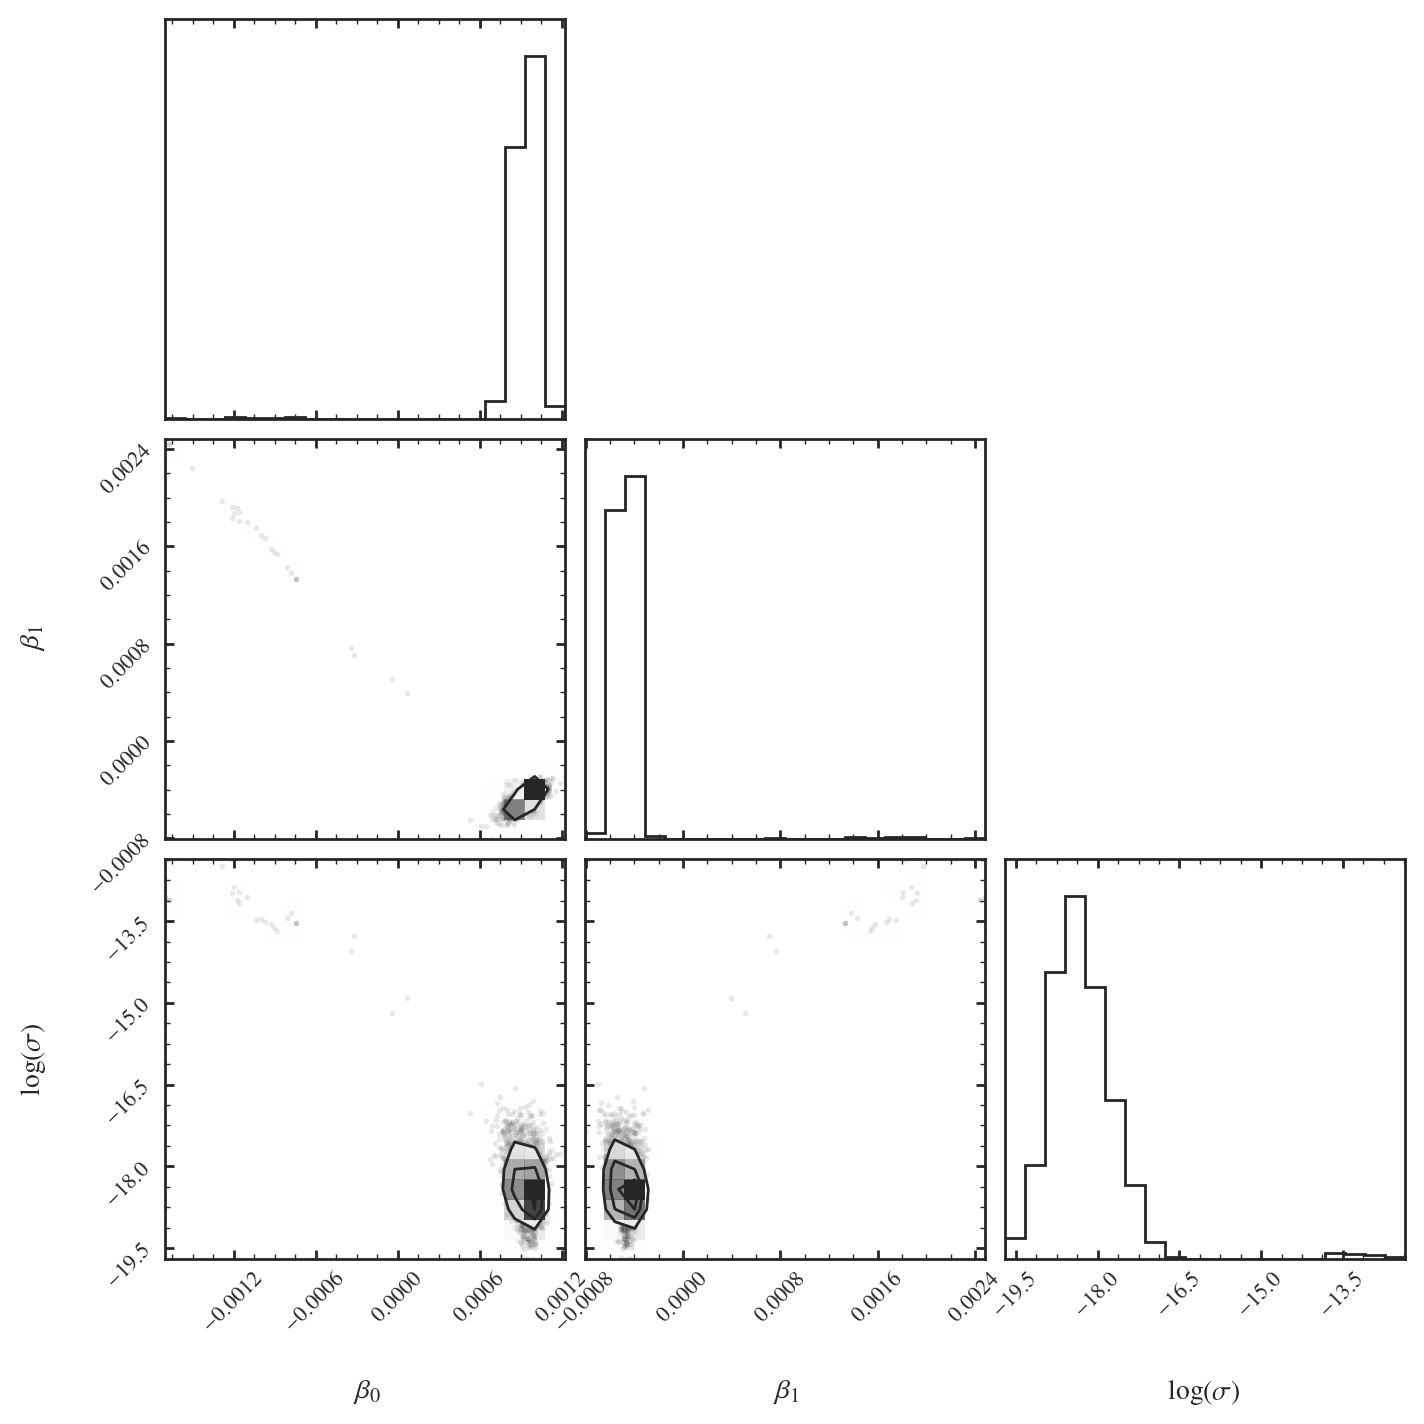

In [62]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 9.41e-04 + 7.65e-05 - 6.24e-05
$\beta_1$ = -4.76e-04 + 5.91e-05 - 5.82e-05
$\log(\sigma)$ = -1.84e+01 + 4.79e-01 - 5.99e-01
9.740e-04  ±  9.027e-05
-4.584e-04  ±  7.698e-05


array([ 0.00097402, -0.00045845])

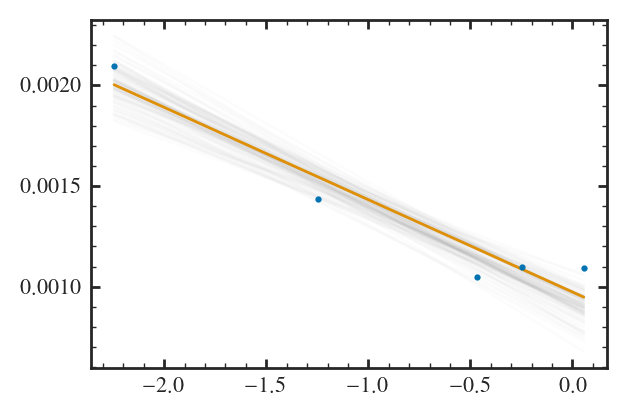

In [63]:
mcmc_utils.plot_posterior(lin_model, obs, samples)
fit_ls(obs, lin_ls)


# M factor

In [64]:
obs0 = get_yield_table("cristallo11")

In [65]:
obs = get_yield_table("cristallo11", mass_factor = 0.5)

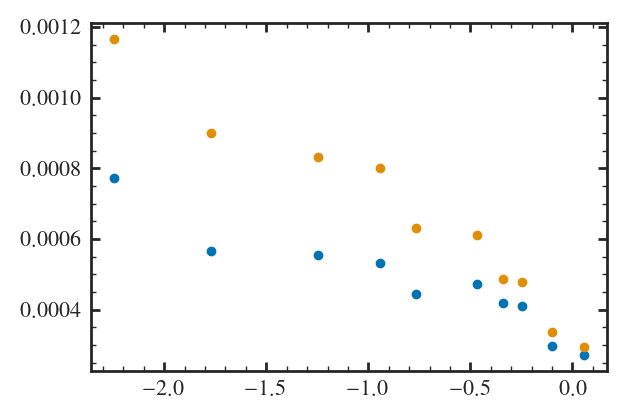

In [66]:
plt.scatter(obs[0], obs[1])
plt.scatter(obs0[0], obs0[1])

100%|████████████████████████████████████████████| 3000/3000 [00:11<00:00, 252.61it/s]


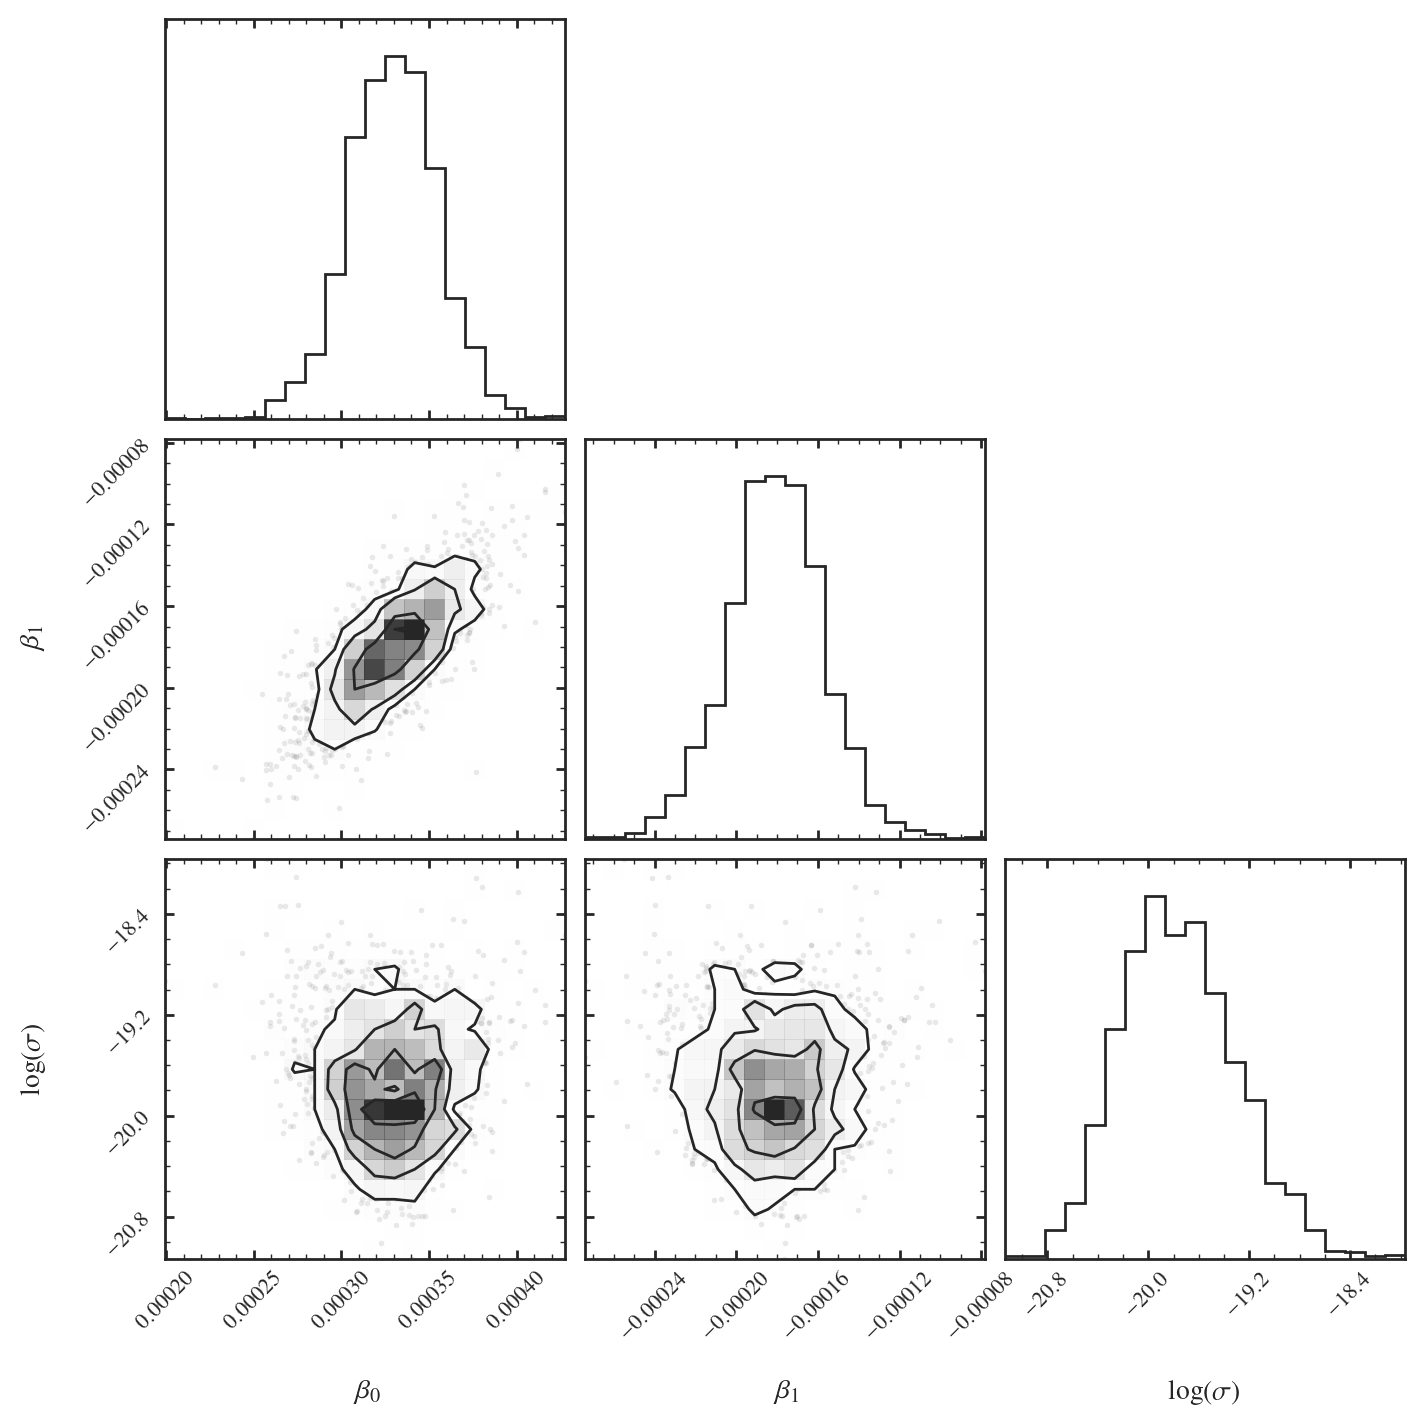

In [67]:
samples = mcmc_utils.run_mcmc(lin_model, obs, N=N, discard=discard)

$\beta_0$ = 3.30e-04 + 2.51e-05 - 2.33e-05
$\beta_1$ = -1.81e-04 + 2.29e-05 - 2.17e-05
$\log(\sigma)$ = -1.98e+01 + 4.25e-01 - 5.00e-01


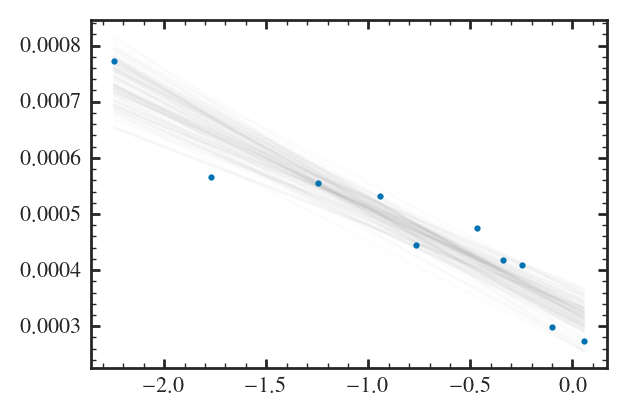

In [68]:
mcmc_utils.plot_posterior(lin_model, obs, samples)

100%|████████████████████████████████████████████| 3000/3000 [00:15<00:00, 193.40it/s]


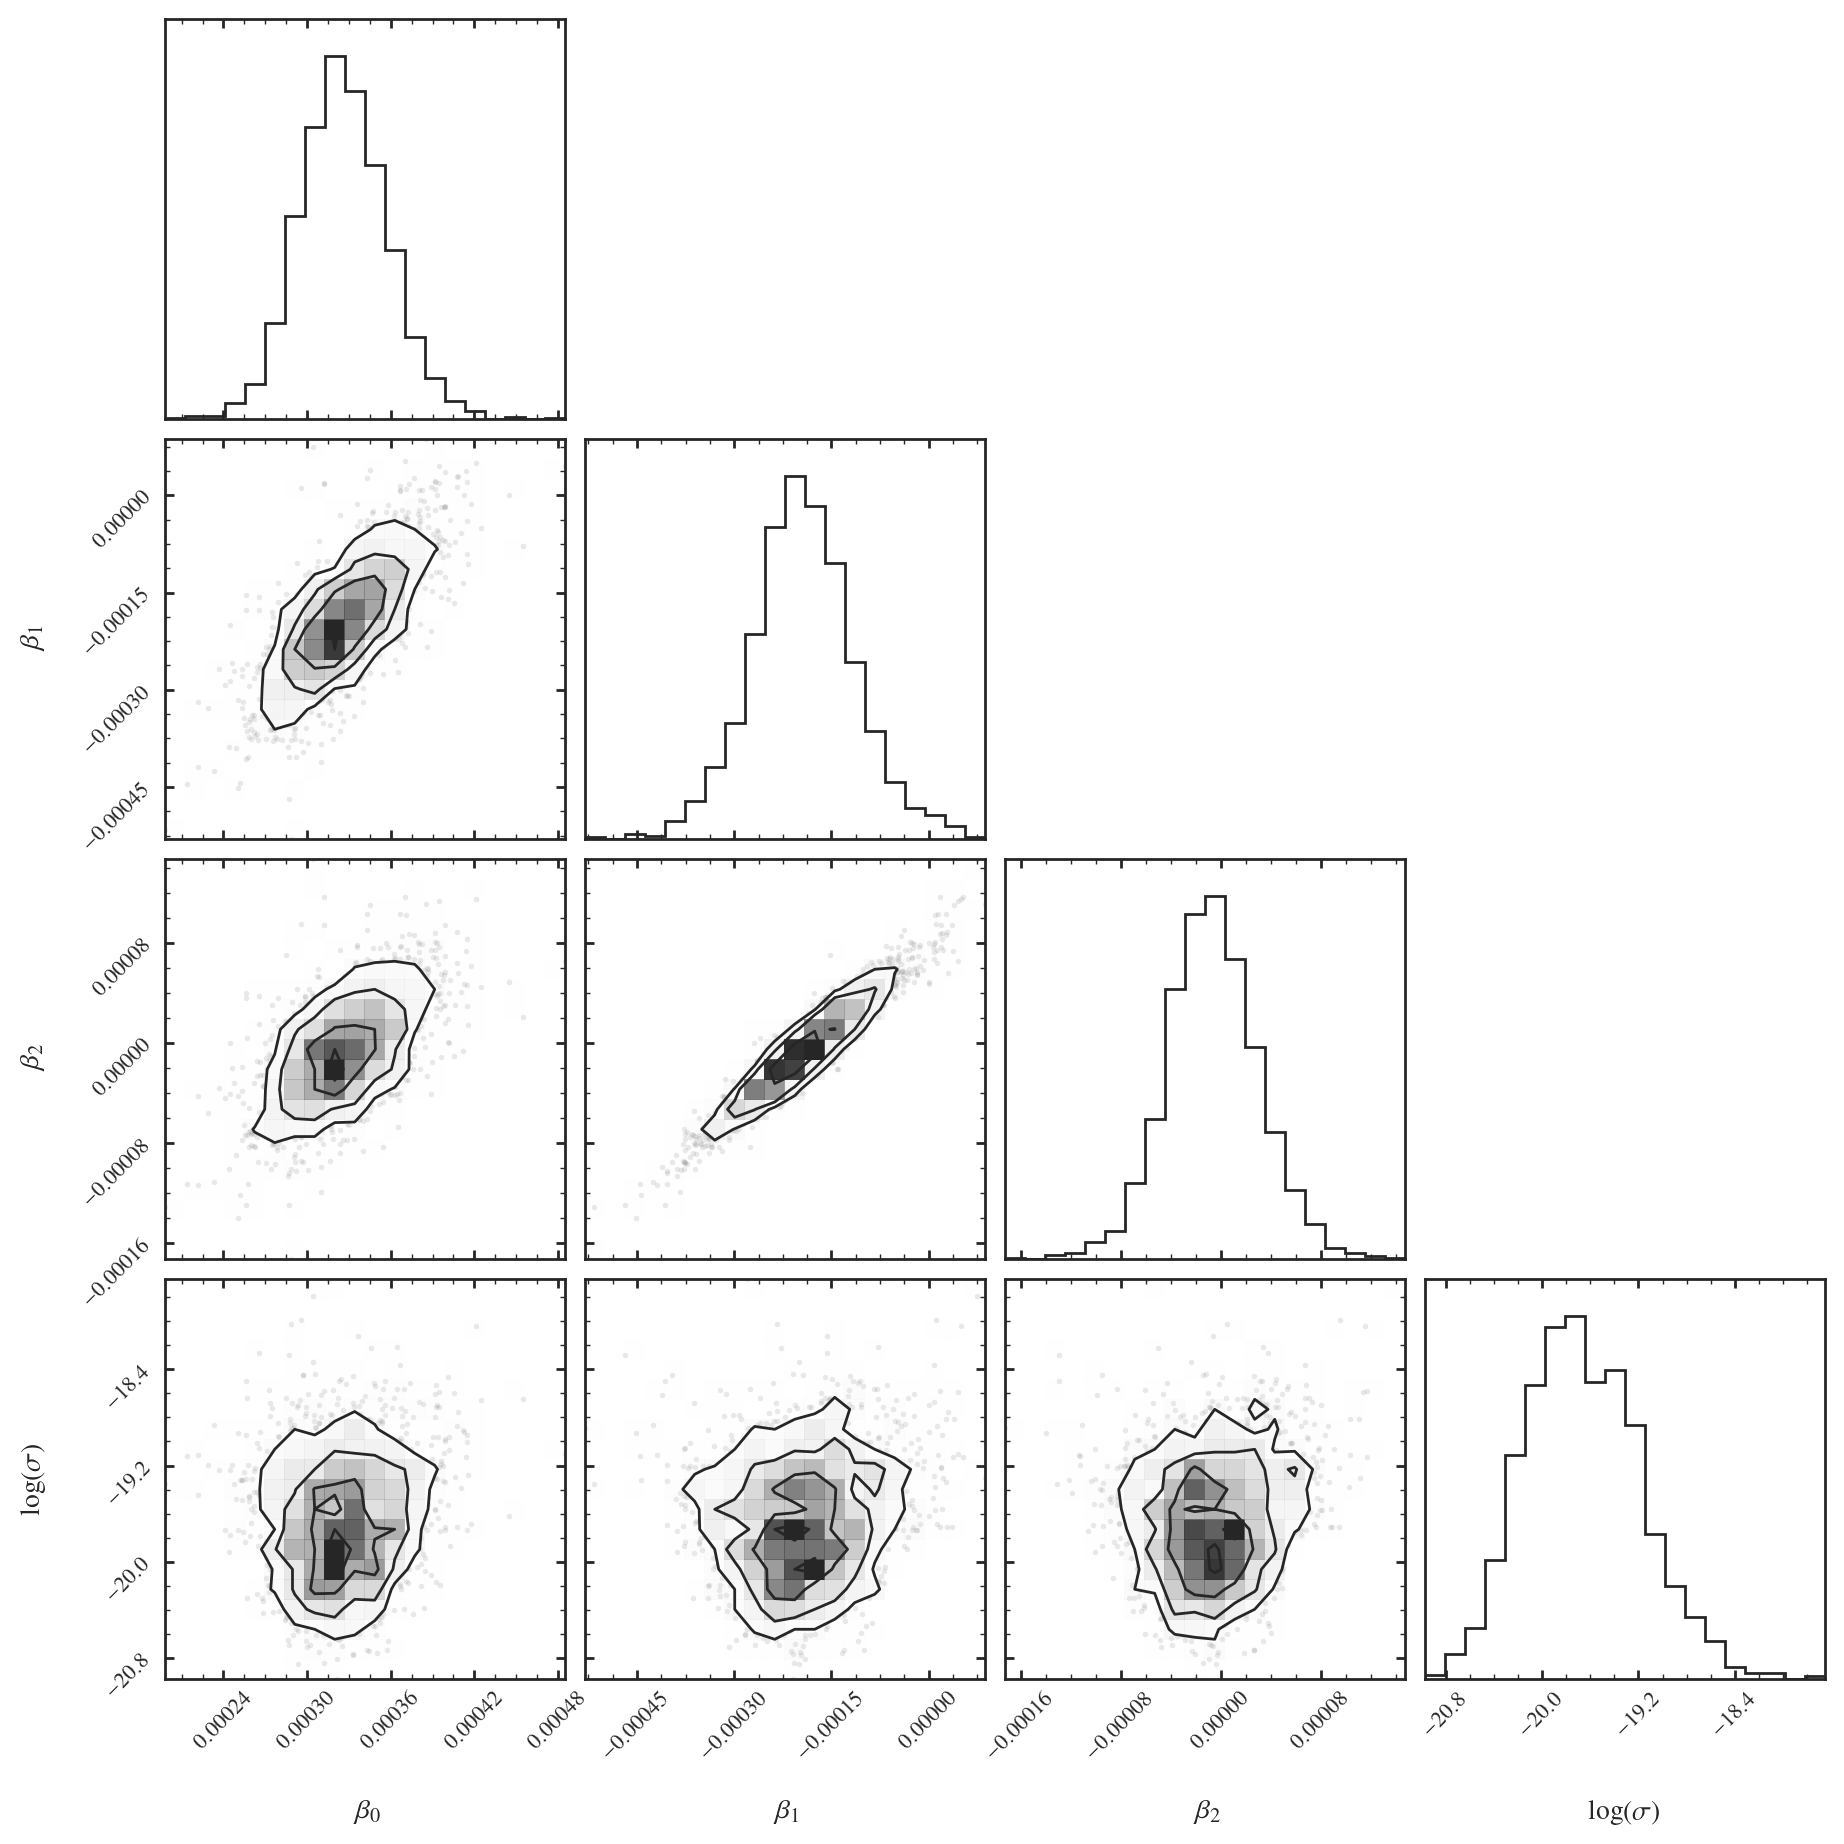

In [69]:
samples = mcmc_utils.run_mcmc(quad_model, obs, N=N, discard=discard)

$\beta_0$ = 3.25e-04 + 3.02e-05 - 3.17e-05
$\beta_1$ = -1.96e-04 + 7.15e-05 - 7.59e-05
$\beta_2$ = -7.67e-06 + 3.32e-05 - 3.64e-05
$\log(\sigma)$ = -1.97e+01 + 4.49e-01 - 4.96e-01


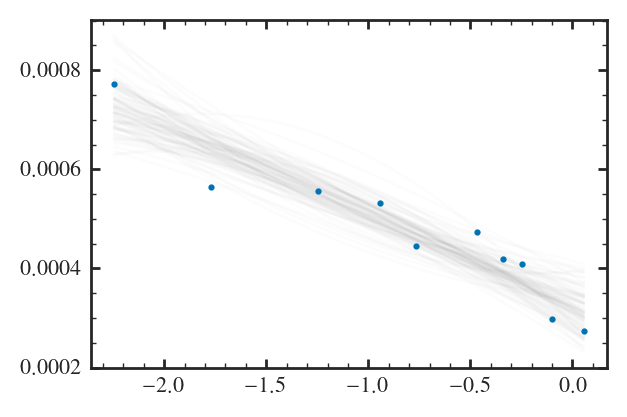

In [70]:
mcmc_utils.plot_posterior(quad_model, obs, samples)

100%|████████████████████████████████████████████| 3000/3000 [00:14<00:00, 200.13it/s]


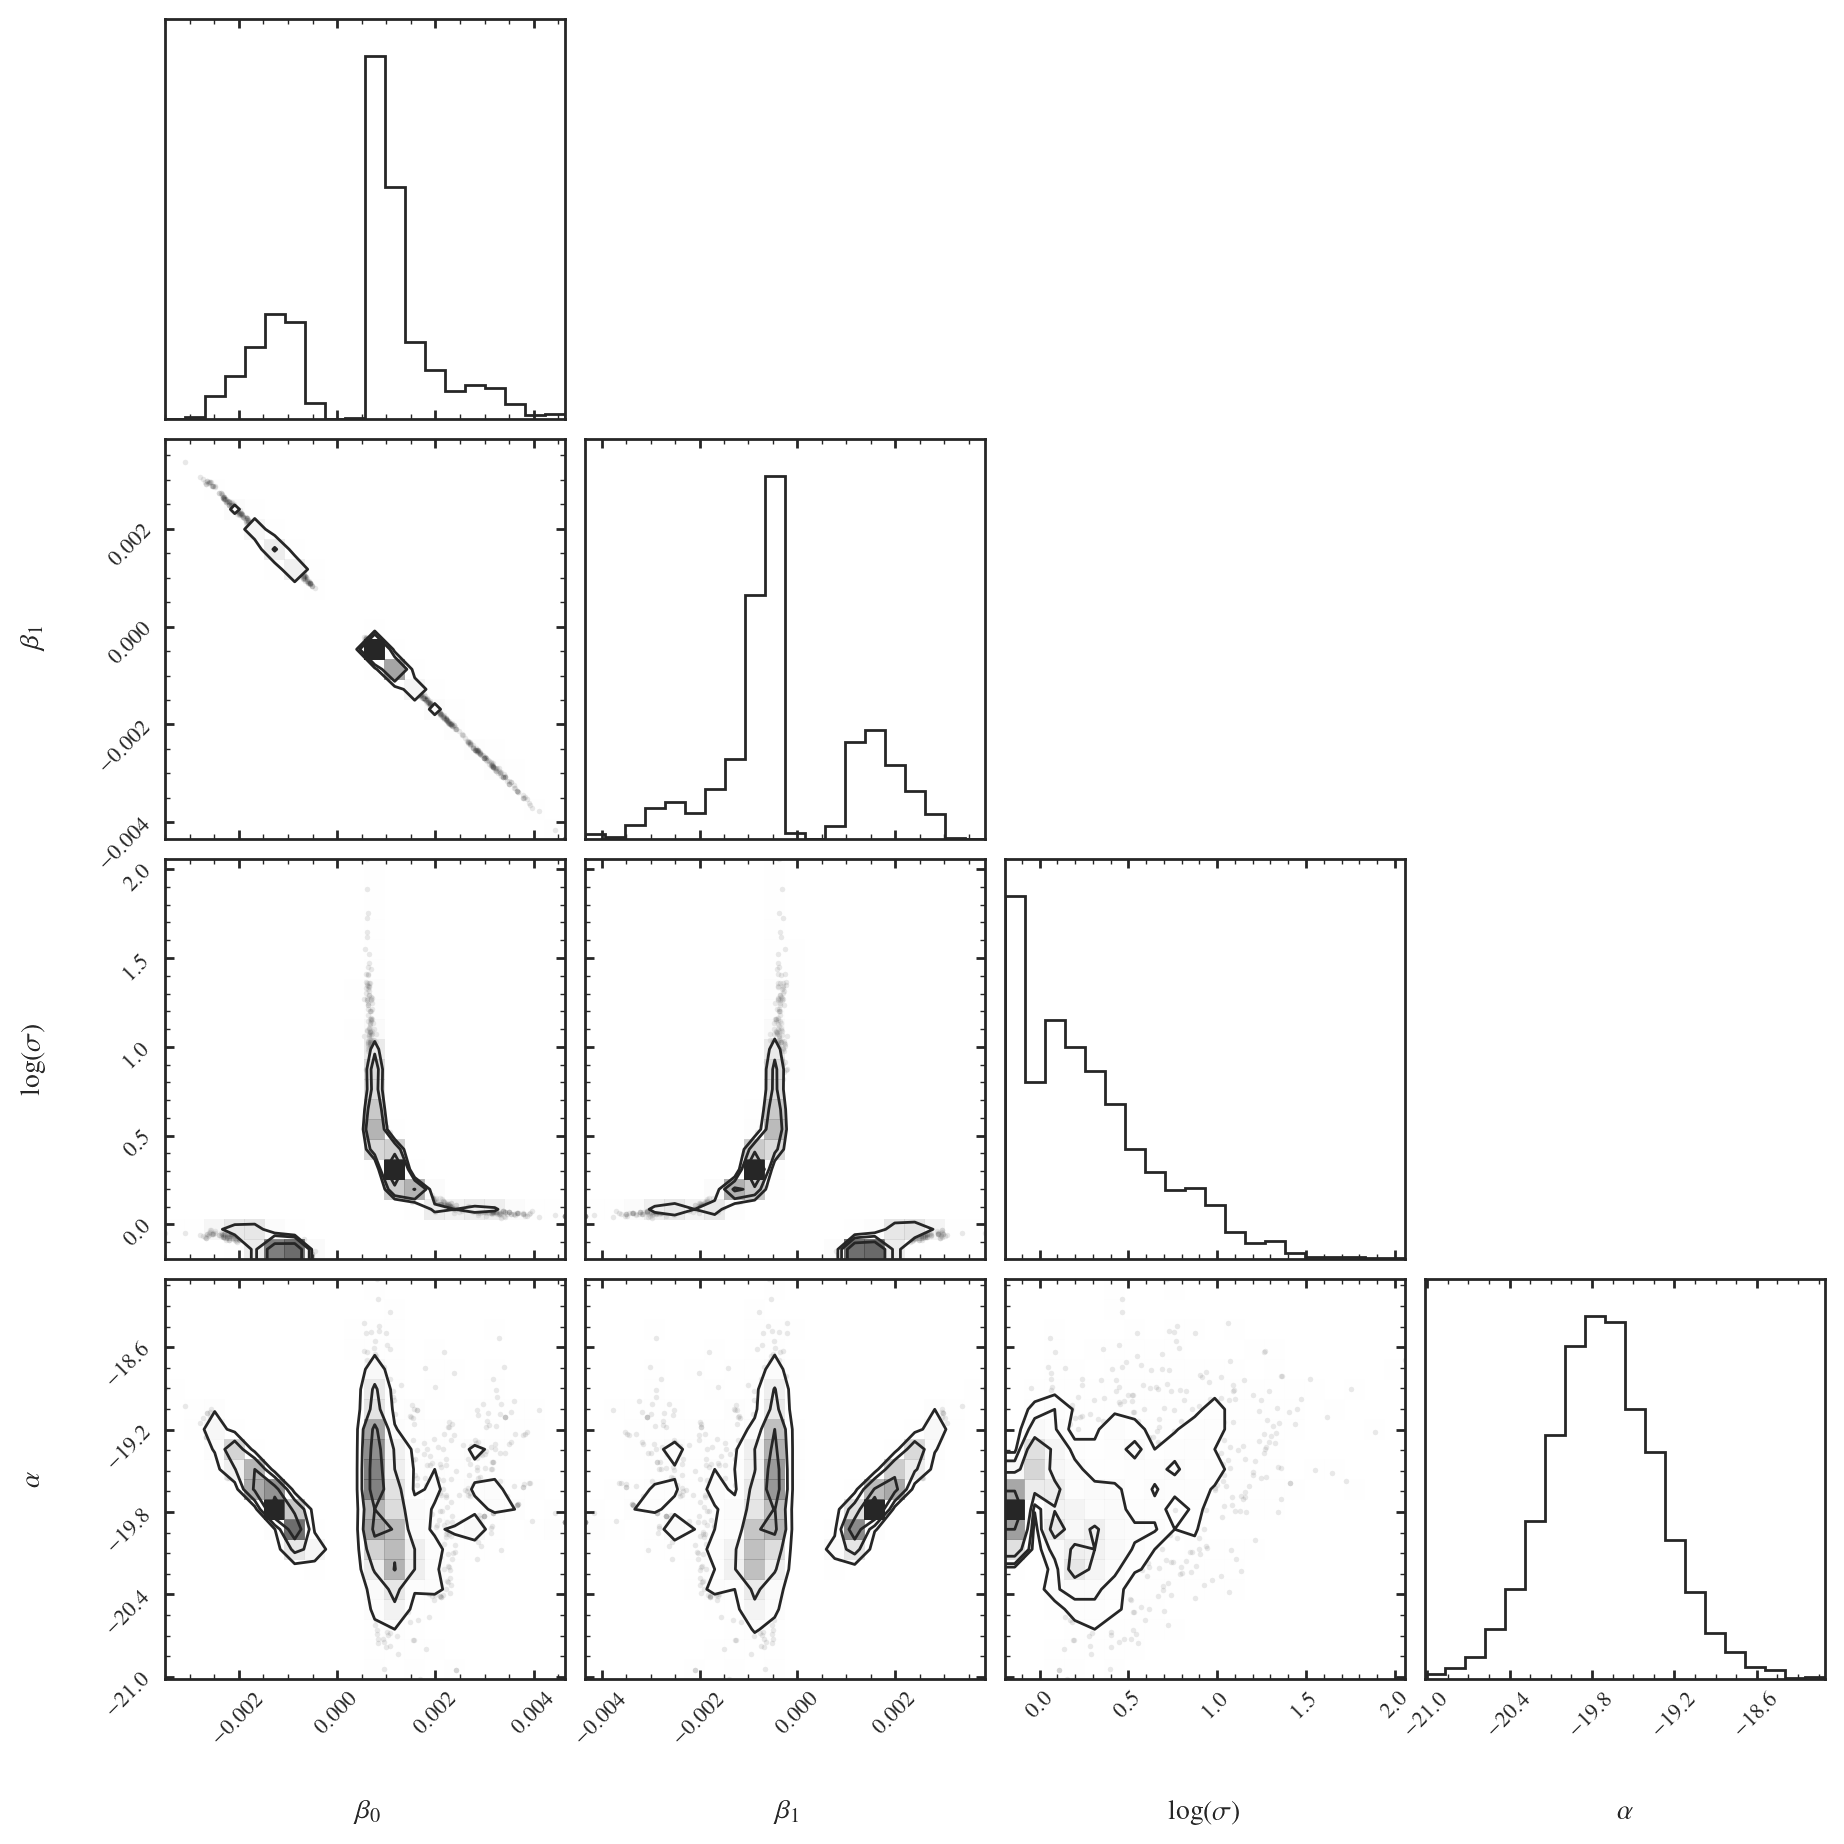

In [71]:
samples = mcmc_utils.run_mcmc(exp_model, obs, N=N, discard=discard)

$\beta_0$ = 8.28e-04 + 2.08e-03 - 7.93e-04
$\beta_1$ = -5.25e-04 + 7.67e-04 - 2.11e-03
$\log(\sigma)$ = 2.04e-01 + 2.98e-01 - 4.82e-01
$\alpha$ = -1.97e+01 + 3.77e-01 - 4.21e-01


(-0.001, 0.002)

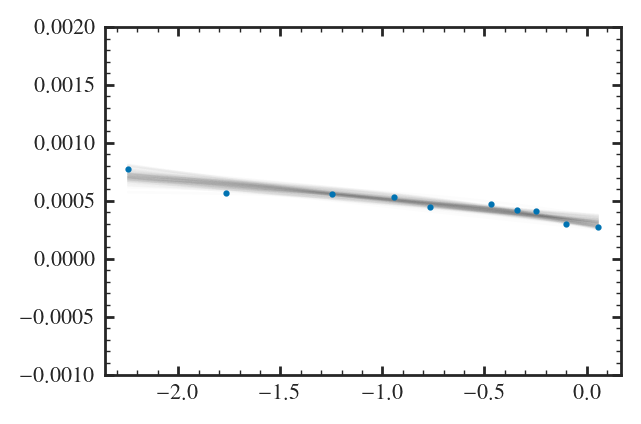

In [72]:
mcmc_utils.plot_posterior(exp_model, obs, samples)
plt.ylim(-1e-3, 2e-3)

In [73]:
get_yield_table

<function __main__.get_yield_table(study, **kwargs)>